In [1]:
import sys
sys.path.append("./py_files/")
sys.path.append("/Users/manuelladron/phd_cd/DL_11785/homework/hw3/hw3p1/mytorch/")

In [2]:
import torch
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
# from build_vocab import Vocabulary
import json
import shutil
import utils
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from ctcdecode import CTCBeamDecoder
import search
import torch.nn as nn
import torch.optim as optim
import utils
import spacy    
import itertools
import collections
import pdb
cuda = torch.cuda.is_available()
cuda

False

#### Fetch Data

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
im_path_arch = "/Users/manuelladron/phd_cd/DL_11785/project/data_collection/architecture/thumbs/big"
im_path_des = "/Users/manuelladron/phd_cd/DL_11785/project/data_collection/design/design/thumbs/big"
im_path_tech = "/Users/manuelladron/phd_cd/DL_11785/project/data_collection/technology/thumbs/big"

tagged_path_arch = "../dataset_/dataset/json_files/architecture_dz-cleaned-tagged.json"
tagged_path_des = "../dataset_/dataset/json_files/design_dz-cleaned-tagged.json"
tagged_path_tech = "../dataset_/dataset/json_files/technology_dz-cleaned-tagged.json"

vocab_path_arch = "../data/architecture_dz-cleaned.json"
vocab_path_des = "../data/design_dz-cleaned.json"
vocab_path_tech = "../data/technology_dz-cleaned.json"

im_paths = [im_path_arch, im_path_des, im_path_tech]
paths_for_vocab = [vocab_path_arch, vocab_path_des, vocab_path_tech]
tagged_files_paths = [tagged_path_arch, tagged_path_des, tagged_path_tech]
im_toy = [im_path_tech]
tagg_toy = [tagged_path_tech]

dataset_new_folder = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/multilabel_classifier/dataset_/dataset/all_tagged_images"

vocab_dict_path = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/data/vocab/vocab-dict.json"
vocab_res_dict_path = "/Users/manuelladron/phd_cd/DL_11785/project/Github_Ambiguity-in-Computational-Creativity-master/data/vocab/vocab-res-dict.json"

In [5]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self, nlp):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.nlp = nlp

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)
    
    
    def get_adj_from_sentence(self, sentence):
        """
        Parses sentence and get a list of cleaned lemmatized adj longer than 1 character. No duplicates
        """
        doc = self.nlp(sentence)
        adj = []
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_ = token.lemma_.lower()
                if len(adj_) > 1:
                    adj.append(adj_)
#         print("adj: ", adj)
        return list(set(adj))
        
    def get_adj_from_all_sentences(self, sentences):
        """
        Calls the function get_adj_from_sentence a sentences number of times
        """
        adj = []
        for sentence in sentences:
#             print("sentence: ", sentence)
            sent_adj = self.get_adj_from_sentence(sentence)
            adj.extend(sent_adj)
        return adj

In [6]:
def build_vocabulary(path, save_dict_path, nlp):
    """
    Builds vocabulary with the entirity of the datasets
    """
    
    # Create Utils instance
    U = utils.Utils()
    data_raw = U.jsons_to_list(path)
    
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary(nlp)
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>') 

    all_adjs = []
    for f, file in enumerate(data_raw): # 0_arch 1_des 2_...
        print("Starting building vocab corresponding to file: \n", f)
        for i in range(len(file)): # 900 samples
            sample_dict = file[i]                             
            sample_text = sample_dict['text'] # this is a list with strings
            adj_list = vocab.get_adj_from_all_sentences(sample_text)
            all_adjs.append(adj_list)
        print("....Finishing vocab file: \n", f)

    for sublist in all_adjs:
        for adj in sublist:
            vocab.add_word(adj)
            
    # Save vocab in dict 
    with open(save_dict_path, 'wb') as f:
        pickle.dump(vocab, f)
    f.close()
    return vocab

In [7]:
def load_vocab(file_path):
    
    # open file
    f = open(file_path, 'rb')
    
    # dump info to that file
    data = pickle.load(f)
    
    # close file
    f.close()
    
    # return vocab
    return data

In [8]:
VOCAB = load_vocab(vocab_res_dict_path)

In [9]:
len(VOCAB)

2803

In [10]:
ALPHABET = 'abcdefghijklmnopqrstuvwxyz'
NUMBERS = '0123456789'

class PreprocessedData(object):
    def __init__(self, files_paths, images_paths, new_folder, nlp, vocab):
        """
        train_file_path = list with files
        test_file_path = list with files
        """
        
        # Create pipe
        self.nlp = nlp
        
        # Inherit vocabulary
        self.VOCAB = vocab
        
        # Call to utils
        self.Utils = utils.Utils()
        
        # paths to jsons
        self.files_paths = files_paths
        
        # path to image folders
        self.images_paths = images_paths

        # path to new image_path
        self.new_image_path = new_folder
        
        # Dataset
        self.train_data = None 
        self.dev_data = None
        self.train_labels = None
        self.dev_labels = None
        
        # Run
        print("\nRunner....")
        self.runner()
        
    ############## PROCESSING DATA ##############
    def get_adj_from_sentence(self, sentence):
        """
        Parses sentence and get a list of cleaned lemmatized adj longer than 1 character. No duplicates
        """
        doc = self.nlp(sentence)
        adj = []
        for token in doc:
            if token.pos_ == 'ADJ':
                adj_ = token.lemma_.lower()
                if len(adj_) > 1:
                    adj.append(adj_)
        return list(set(adj))
        
    def get_adj_from_all_sentences(self, sentences):
        """
        Calls the function get_adj_from_sentence a sentences number of times
        """
        adj = []
        for sentence in sentences:
            sent_adj = self.get_adj_from_sentence(sentence)
            adj.extend(sent_adj)
        return adj
        
    def is_valid(self, images, adj):
        """
        Avoids empty data samples
        """
        if adj == []: return False
        if images == []: return False
        return True
    
    
    def handle_N_labels(self, list_of_labels, N_labels):
        """
        Truncates or pads list of labels according to N_labels
        """
        pad_with = list_of_labels[0]
        if len(list_of_labels) == N_labels:
            return list_of_labels
        
        elif len(list_of_labels) < N_labels:
            diff = N_labels - len(list_of_labels)
            for i in range(diff):
                list_of_labels.append(pad_with)
        else:
            list_of_labels = list_of_labels[:N_labels]
        
        return list_of_labels
    
    def get_images_labels(self, files):
        """
        Parse json files and outputs train_data (image) + numpy array labels for multi-label classification
        """
        train_data = []
        labels = dict()
        
        for f, file in enumerate(files): # 0_arch 1_des 2_tech
            im_per_section = []     # these ones have the same length
            for i in range(len(file)): # 902 samples architecture, 675 samples design  
                sample_dict = file[i]                  # dictionary
                sample_text = sample_dict['text']      # list with sentences (strings)
                text_tags = sample_dict['text-tags']
                sample_images = sample_dict['images']
                image_tags = sample_dict['image-tags']
                  
                # 2) Select valid text
                tagged_text = [sample_text[ALPHABET.index(letter)].lower() for letter in text_tags]
                
                # 3) Get adjectives from valid text
                adj = self.get_adj_from_all_sentences(tagged_text)
                
                # 4) Select valid images
                tagged_images = [sample_images[int(letter)] for letter in image_tags]
                
                if self.is_valid(tagged_images, adj):
                    # Add special token '<end>' as a label
                    adj.append('<end>')
#                     adj = self.handle_N_labels(adj, 1)
                    for image in tagged_images:
                        labels[image[5:]] = adj
                    im_per_section.append(tagged_images)
            
            train_data.append(im_per_section)

        return train_data, labels
                    
    def convert_labels_to_int(self, labels):
        """
        Convert labels to int array
        """
        labels_int = dict()
        for key, val in labels.items():
            label_array = np.zeros(len(val), dtype = int)
            for i, label in enumerate(val):
                # Try add label in vocabulary. If already exists, nothing happens, just get the idx
                self.VOCAB.add_word(label)
                idx = self.VOCAB.word2idx[label]
                label_array[i] = idx
            labels_int[key] = label_array
        
        return labels_int
    
    def copy_wrapper(self, list_dataset_per_section, curr_folders, dest_folder):
        self.all_failed_samples = []
        for i, dataset in enumerate(list_dataset_per_section):
            self.all_failed_samples.append(self.copy_dataset(dataset, curr_folders[i], dest_folder))
        
    def copy_dataset(self, image_dataset, curr_folder, dest_folder):
        fail_samples = self.Utils.copy_files(image_dataset, curr_folder, dest_folder)
        return fail_samples
    
    def flatten(self, S):
        if S == []:
            return S
        if isinstance(S[0], list):
            return self.flatten(S[0]) + self.flatten(S[1:])
        return S[:1] + self.flatten(S[1:])
    
    def change_name(self, dataset):
        dataset = self.flatten(dataset)
        for i, image in enumerate(dataset):
            newname = image[5:]
            dataset[i] = newname
        return dataset
            
    def remove_dups(self, l):
        seen = []
        dups = []
        for sample in l:
            if sample not in seen:
                seen.append(sample)
            else:
                dups.append(sample)
        
        for dup in dups:
            if dup in l:
                l.remove(dup)
        return l
    
    def remove_dups_labels(self, x):
        seen = []
        dups = []
        for key,val in x.items():
            if key not in seen:
                seen.append(key)
            else:
                dups.append(key)
        
        for dup in dups:
            if dup in x.keys():
                del x[dup]
    
    def flip_dictionary(self, dic):
        """
        Flips dictionary of labels. From key=image_name, val=adj --> key=adj, val=list of images
        """
        flipped = {}
        for k,val_list in dic.items():
            for v in val_list:
                if v not in flipped:
                    flipped[v] = [k]
                else:
                    flipped[v].append(k)
        return flipped
    
    def take(self, n, iterable):
        "Return first n items of the iterable as a list"
        return list(islice(iterable, n))
    
        
    def smaller_dataset(self, dictionary, N):
        """
        Counts the times an adjective appears in the dictionary. Grabs the N most frequent. 
        Makes a new data dictionary out of this. 
        """
        count_labels = collections.Counter( v[0] for v in dictionary.values())
        print(count_labels)
        sorted_count = sorted(count_labels.items(), key=operator.itemgetter(1), reverse=True)
        sc = self.take(N, sorted_count) # this is a list of tuples (adjective, counter)
        print(sc)
        sc_keys = []
        for i in range(len(sc)):
            sc_keys.append(sc[i][0]) # that's why we are grabbing here the first element of the tuple -> adj
    
        shorter_dict = {}
        for k,v in dictionary.items():
            if v[0] in sc_keys:
                shorter_dict[k] = v
    
        return shorter_dict

    
    def split_train_val(self, dic, percentage):
        val_set = {}
        train_set = {}

        for k, v in dic.items():
            if len(v) > 3:
                keep = int(len(v)*percentage) #for train_set
                train_set[k] = v[:keep]
                val_set[k] = v[keep:]
            else:
                train_set[k] = v
        
        return train_set, val_set
    
    def partition_data(self, percentage):
                
        # Flipped current dict
        flipped = self.flip_dictionary(self.labels)
        
        # Split dictionary into train and validation set 
        inv_train_set, inv_val_set = self.split_train_val(flipped, percentage)
        
        # Flip them back
        self.label_train = self.flip_dictionary(inv_train_set)
        self.label_val = self.flip_dictionary(inv_val_set)
        
        # Store all images_names in corresponding folders
        self.train_d = []
        self.val_d   = []
        
        for i in range(len(self.train_data)):
            image_name = self.train_data[i]
            if image_name in self.label_train.keys():
                self.train_d.append(image_name)
            if image_name in self.label_val.keys():
                self.val_d.append(image_name)

    
    def special_token_end(self, dictionary):
        """
        Moves <end> to the end of the list
        """
        for list_of_values in dictionary.values():
            list_of_values.sort(key = '<end>'.__eq__)
                
            
    
    def runner(self):
        files = self.Utils.jsons_to_list(self.files_paths)    
        self.train_data, self.labels = self.get_images_labels(files) # keep track of the length of these variables
        
        # This puts all the images in one folder. 
#         self.copy_wrapper(self.train_data, self.images_paths, self.new_image_path)
        
        # Change names of self.train
        self.train_data = self.change_name(self.train_data)
        
        # Get most common 100 adj as dataset
#         self.labels = self.smaller_dataset(self.labels, 100)
        
        # Partition data
        self.partition_data(0.7)
        
        print("before removing dups: ", len(self.label_train), len(self.label_val))
        # remove dups in labels
        self.remove_dups_labels(self.label_train)
        self.remove_dups_labels(self.label_val)
        print("after removing dups: ", len(self.label_train), len(self.label_val))
        
        # Make sure <end> is at the end :) of the sequence
        self.special_token_end(self.label_train)
        self.special_token_end(self.label_val)
        
        # This needs to be done after flattening
        self.label_train_int = self.convert_labels_to_int(self.label_train)
        self.label_val_int = self.convert_labels_to_int(self.label_val)
        
        # Removes potential duplicates
        self.remove_dups(self.train_d)
        self.remove_dups(self.val_d)


In [11]:
dataset = PreprocessedData(tagged_files_paths, im_paths, dataset_new_folder, nlp, VOCAB)

Utils object created...

Runner....
Json_file: 0, length: 902, type: <class 'list'>
Json_file: 1, length: 888, type: <class 'list'>
Json_file: 2, length: 166, type: <class 'list'>
before removing dups:  4328 3283
after removing dups:  4328 3283


In [12]:
# dataset_toy = PreprocessedData(tagg_toy, im_toy, dataset_new_folder, nlp, VOCAB)

In [13]:
len(dataset.label_train), len(dataset.label_val)

(4328, 3283)

In [14]:
len(dataset.train_d), len(dataset.val_d)

(4328, 3283)

In [15]:
dataset.train_data[2]

'77768d2fcb5367b4786813059029a7e886a13dde.jpg'

In [16]:
dataset.label_train

{'3c0a85006109b91ec636dbf68b1f9237abdc32ca.jpg': ['generous', 'full', '<end>'],
 'd927842dfd2c67d0ef2fdc624427a58f0d3c9434.jpg': ['generous', 'full', '<end>'],
 '77768d2fcb5367b4786813059029a7e886a13dde.jpg': ['generous', 'full', '<end>'],
 '9ab9a4a8979dd6485f7d6b32a44f127bbefc3d2c.jpg': ['generous', 'full', '<end>'],
 '0b4d700507c75a79ca30e970ade1da8702da3d6c.jpg': ['generous', 'full', '<end>'],
 '50abf90ec81f2bb1e8a8faac1d2fa52a7928991f.jpg': ['generous', 'full', '<end>'],
 '40d561c04f4a8b9564e53201d85a13dd1092f239.jpg': ['generous', 'full', '<end>'],
 'a7d6c07e6cb3930096ebda922fff72f5d392ea2b.jpg': ['generous', 'full', '<end>'],
 'ab76c255ebdc2c6b78f2ab2aabaa136a31bf167b.jpg': ['generous', 'full', '<end>'],
 '2ecd7c1f54861ec8cfee73c6b6caca23418137a5.jpg': ['generous', 'full', '<end>'],
 '204562d7b90910a5a24ac829ebfc78b2bd219c67.jpg': ['generous',
  'strong',
  'curved',
  'external',
  'glazed',
  'residential',
  'broad',
  '<end>'],
 '437c008fcbb090c3a36a9cc398c3bad7019aa4e4.jpg':

In [17]:
def see_images(N):
    # Read using Pillow
    for i in range(N):
        name = dataset_new_folder + "/" + dataset.train_data[i+1000]
        image = np.array(Image.open(name))
        print(image.shape)
        plt.imshow(image)
        plt.show()

(115, 128, 3)


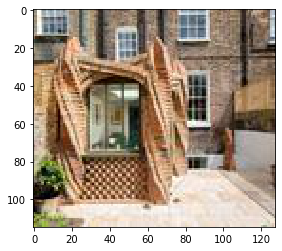

(128, 90, 3)


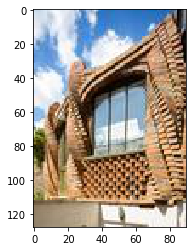

(128, 96, 3)


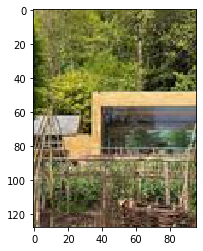

In [18]:
see_images(3)

In [19]:
class ImageDataset(Dataset):
    def __init__(self, dataset, train=True):
        self.data = dataset
        if train:
            self.image_labels_string = dataset.label_train    # dictionary
            self.image_labels_int = dataset.label_train_int
            self.image_names = dataset.train_d  # list with image_names
        
        else:
            self.image_labels_string = dataset.label_val    # dictionary
            self.image_labels_int = dataset.label_val_int
            self.image_names = dataset.val_d  # list with image_names

        self.name2idx()
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.idx2name[index]
        name = dataset_new_folder + "/" + self.image_names[index]
        img = Image.open(name)
        
        img = transforms.Compose([
        transforms.Resize((64, 64)),
#         transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])(img)
        
        label = torch.from_numpy(self.image_labels_int[image_name])
        return img, label
    
    def name2idx(self):
        self.name2idx = dict()
        self.idx2name = dict()
        for i, key in enumerate(self.image_labels_string.keys()):
            self.name2idx[key] = i
            self.idx2name[i] = key
            
def collate(sequence):
    """
    "the input of this function is the output of function __getitem__"
    "this gets BATCH_SIZE times GETITEM! "
    if batch_Size == 2 --> sequence is a list with length 2. 
    Each list is a tuple (image, label) = ((3,64,64), label_length)
    """

#     print("sequence:")
#     print(sequence)
#     print("----- 0")
#     print(sequence[0])
#     print("------ 1")
#     print(sequence[1])
    # Concatenate all images in the batch
    inputs = torch.cat(([  batch_[0].view(-1, 3, 64, 64) for batch_ in sequence]), dim=0)
    
    # Pad labels with max_sequence_label
    targets  = pad_sequence([batch_[1] for batch_ in sequence], batch_first=True)
    targets_length  = torch.LongTensor([len(batch_[1]) for batch_ in sequence])     
    
    #print("\nInputs: {}\nTargets: {}\nTargets length:{}\n".format(len(inputs), targets.shape, targets_length))
    return inputs, targets, targets_length


In [20]:
class ImageDataset2(Dataset):
    def __init__(self, dataset):
        self.data = dataset
        self.image_labels_string = dataset.labels    # dictionary
        self.image_labels_int = dataset.labels_int
        self.image_names = dataset.train_data  # list with image_names
        self.name2idx()
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.idx2name[index]
        name = dataset_new_folder + "/" + self.image_names[index]
        img = Image.open(name)
        
        img = transforms.Compose([
        transforms.Resize((64, 64)),
#         transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])(img)
        
        label = torch.from_numpy(self.image_labels_int[image_name])
        return img, label
    
    def name2idx(self):
        self.name2idx = dict()
        self.idx2name = dict()
        for i, key in enumerate(self.image_labels_string.keys()):
            self.name2idx[key] = i
            self.idx2name[i] = key
            
def collate(sequence):
    """
    "the input of this function is the output of function __getitem__"
    "this gets BATCH_SIZE times GETITEM! "
    if batch_Size == 2 --> sequence is a list with length 2. 
    Each list is a tuple (image, label) = ((3,64,64), label_length)
    """

    """
    print("\nCollate function....")
    print("Sequence: ")
    print(len(sequence))
    print("seq[0] = ", sequence[0][0].shape, sequence[0][1].shape)
    print("")
    print("Seq[1] = ", sequence[1][0].shape, sequence[1][1].shape)
    """
    
    # Concatenate all images in the batch
    inputs = torch.cat(([  batch_[0].view(-1, 3, 64, 64) for batch_ in sequence]), dim=0)
    
    # Pad labels with max_sequence_label
    targets  = pad_sequence([batch_[1] for batch_ in sequence], batch_first=True)
    targets_length  = torch.LongTensor([len(batch_[1]) for batch_ in sequence])     
    
#     print("\nInputs: {}\nTargets: {}\nTargets length:{}\n".format(len(inputs), targets.shape, targets_length))
    return inputs, targets, targets_length


In [21]:
dataset_train = ImageDataset(dataset, train=True)

In [22]:
dataset_val = ImageDataset(dataset, train=False)

In [23]:
len(dataset_train), len(dataset_val)

(4328, 3283)

In [24]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [150]:
class DECODER(nn.Module):
    """
    The only combination I get to work is using the output of the LSTM, not the hiddens. 
    Can be either 1 direction or 2.
    
    """

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, max_seq=5):
        super(DECODER, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.max_seq = max_seq
        self.n_layers = n_layers
        self.output_dim = output_dim
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout,
                           batch_first=True)

        # linear layer
        multiplier = 2 if bidirectional else 1
#         input_size = hidden_dim * (n_layers * multiplier) # ---> if using hiddens (n_layers important)
        input_size = hidden_dim * (multiplier) # --------------> nlayers is not correct here! think of diagram!
        self.fc = nn.Linear(input_size, output_dim)
            
            
    def forward_process(self, image_feature, labels, labels_lengths):
        print("\n----FORWARD----")
        # embedding_size = 64
        
        # labels = [batch size, max_length]
        # image_feature is [batch_size, embedding size]
        print("\nimage_features as they come: ", image_feature.shape)
        
        # image feature unsqueeze(1) --> [batch_size, 1, embedding_size] 
        print("\nimage_features unsqueeze(1): ", image_feature.unsqueeze(1).shape)
        
        print("\nLabels as they come: ", labels.shape)
        embedded_label = self.embedding(labels)
        # embedded_label = [batch size, label_len, emb dim] ---> say [2, 5, 64] : 64 dimensions for each of the 5 labels 
        print("\nAfter embedding layer: ", embedded_label.shape)
        
        # Concatenate image_feature + label_feature
        embeddings = torch.cat((image_feature.unsqueeze(1), embedded_label), 1)
        # embedding = [batch_size, length of label + 1 (dim of image), 64]
        print("\nAfter concatenating image + caption: ", embeddings.shape)
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embeddings, labels_lengths, enforce_sorted=False, batch_first=True)
        #packed_embdded = [XXXX, emb dimension]
#         print("\nAfter packing the embedding layer: ", packed_embedded[0].shape)

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
#         packed_output, (hidden, cell) = self.lstm(embeddings)
        #hidden = [batch size, num layers * num directions, hid dim]
        #cell = [batch size, num layers * num directions, hid dim]
        print("\nPacked output of LSTM: ", packed_output[0].shape)
        # packed output -> [8, 1024]
        # concat the final forward and backward hidden state
        
        # hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1) # THIS WAS WORKING
        hiddens = [hidden[-i,:,:] for i in range(hidden.shape[0])]
        hidden = torch.cat(hiddens, dim = 1)
        print("\nHidden shape: ", hidden.shape)
        #hidden = [batch size, hid dim * num directions]
        
        dense_outputs = self.fc(packed_output[0])
#         dense_outputs = self.fc(hidden)
#         print("\ndense outputs: ", dense_outputs.shape)

        return dense_outputs

    def forward2(self, image_feature, labels, labels_lengths):
        # embedding_size = 64
        
        # --------------------------------   SHAPES -----------------------------------------------------
        # labels ----------------------> [batch size, max_length]  they come padded to go through the data loader
        # image_feature is ------------> [batch_size, embedding size]
        # image feature unsqueeze(1) --> [batch_size, 1, embedding_size] 
        # embedded_label --------------> [batch size, max_length, emb dim] (64 dimensions for each of the 5 labels)
        # embeddings (img + labels) ---> [batch_size, max_length + 1 (dim of image), embedding_shape]
        # packed_embdded --------------> [XXXX, emb dimension]
        # out lstm shape --------------> [seq_len, batch_size, hidden_dim * directions (2 if bidirectional else 1)])
        # Hidden lstm shape -----------> [batch_size, hidden_size*num_layers])
        # Cell lstm shape -------------> [directions * layers, batch_size, hidden_size])
        
        embedded_label = self.embedding(labels)

        # Concatenate image_feature + label_feature
        embeddings = torch.cat((image_feature.unsqueeze(1), embedded_label), 1)
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embeddings, labels_lengths, 
                                                            enforce_sorted=False, batch_first=True)

        # IMPORTANT: The lstm input is the packed version of the concatenation of image + label embedding!
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # concat the final forward and backward hidden state --> NOT USING THIS ONE
        hiddens = [hidden[-i,:,:] for i in range(hidden.shape[0])]
        hidden = torch.cat(hiddens, dim = 1)

        dense_outputs = self.fc(packed_output[0])

        return dense_outputs
    
    
    def forward(self, image_feature, labels, labels_lengths):
        # embedding_size = 64
        batch_size = labels.shape[0]
        embedding_size = image_feature.shape[1]
        
        #print("batch size: {}, embedding size: {}".format(batch_size, embedding_size))
        # --------------------------------   SHAPES -----------------------------------------------------
        # labels ----------------------> [batch size, max_length]  they come padded to go through the data loader
        # image_feature is ------------> [batch_size, embedding size]
        # image feature unsqueeze(1) --> [batch_size, 1, embedding_size] 
        # embedded_label --------------> [batch size, max_length, emb dim] (64 dimensions for each of the 5 labels)
        # embeddings (img + labels) ---> [batch_size, max_length + 1 (dim of image), embedding_shape]
        # packed_embdded --------------> [XXXX, emb dimension]
        # out lstm shape --------------> [seq_len, batch_size, hidden_dim * directions (2 if bidirectional else 1)])
        # Hidden lstm shape -----------> [batch_size, hidden_size*num_layers])
        # Cell lstm shape -------------> [directions * layers, batch_size, hidden_size])
        # REturn ----------------------> [seq_len * batch, vocab size]
        # Using pad packed ------------> [seq_len, batch, vocab size]
        embedded_label = self.embedding(labels)

        # Concatenate image_feature + label_feature
        embeddings = torch.cat((image_feature.unsqueeze(1), embedded_label), 1)
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embeddings, labels_lengths, 
                                                            enforce_sorted=False, batch_first=True)

        # IMPORTANT: The lstm input is the packed version of the concatenation of image + label embedding!
        augmenting_matrix = torch.ones((embedding_size, self.hidden_dim ))
        new_image_feature = torch.mm(image_feature, augmenting_matrix)
        
        c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim))
        h0 = new_image_feature.unsqueeze(0)
    
        """
        print("new_image_feature shape: ", new_image_feature.shape, "expected 32 x 512")
        print("image shape: ", image_feature.shape, "expected 32, 64")
        print("h0 shape: ", h0.shape, "expected: 1, 32, 512")
        print("packed embedded shape: ", packed_embedded)
        """
        packed_output, (hidden, cell) = self.lstm(packed_embedded, (h0, c0))
        #print("packed output shape: ", packed_output[0].shape)
        
        # this is for beam search
        logits_lstm, logits_lens = pad_packed_sequence(packed_output) # [seq length, batch, vocab size]
        
        
        # concat the final forward and backward hidden state --> NOT USING THIS ONE
        hiddens = [hidden[-i,:,:] for i in range(hidden.shape[0])]
        hidden = torch.cat(hiddens, dim = 1)

        dense_outputs = self.fc(packed_output[0])
        
        logits_lstm_fc = self.fc(logits_lstm) # [sequence length, batch size, vocab size]
#         print("logits shape: ", logits_lstm_fc.shape)
        temp = torch.zeros((logits_lstm_fc.shape[0], logits_lstm_fc.shape[1], 1))
#         print("temp shape: ", temp.shape)
        plus_one = torch.cat((logits_lstm_fc, temp), dim=2)
#         print("plus one shape: ", plus_one.shape, "expected: seq, 3, 2821")
        return dense_outputs, plus_one, logits_lens
    
    
    def sample_topk(self, features, k=3):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        hiddens, states = self.lstm(inputs)          # hiddens: (batch_size, 1, hidden_size)
        outputs = self.fc(hiddens.squeeze(1))                # outputs:  (batch_size, vocab_size)
        _, predicted = outputs.topk(k)                       # predicted: (batch_size)
        print("predicted: ", predicted)
        sampled_ids.append(predicted.tolist()[0])
        print(sampled_ids)
        return sampled_ids
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        
        
        for i in range(self.max_seq):                            # MAX SEQ LENGTH TO GENERATE LABELS
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.fc(hiddens.squeeze(1))                # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            print("predicted: ", predicted)
            sampled_ids.append(predicted)
            
            # Update inputs 
            inputs = self.embedding(predicted)                   # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    
    
    
    def generate(self, seq, n_words): 
        """
        Given a sequences of words (seq) and a number of words we want to generate (n_words), use the 
        RNN to feed the initial sequence on. Then get the the output of the RNN to get the the probability 
        at the last time step of the sequence. This gets the best word and appends it to the given sequence. 
        At each iteration of the loop, the sequence grows by the best probable word.
        
        A helpful note: this is basically calling forward multiple times in a for loop and modifying the 
        input sequence at each iteration.
        
        RETURNS: A matrix of rows = batch size, (say batch size is 10), then it generates 10 sequences. The
        length of those sequences is n_words.
        """
        with torch.no_grad():
            batch_size = seq.shape[1] 
            generated_words = torch.zeros((batch_size, n_words)) # Prepare the placeholder tensor
            seq = seq.to(DEVICE) # seq x batch
            
            for i in range(n_words):
                
                ### Model self.forward(current_word==seq)
                hidden = None
                embed = self.embedding(seq)
                for j in range(self.nlayers):
                    embed, hidden = self.lstm_list[j](embed, hidden) # 1 x batch_size x hidden_size
                output_lstm = embed
                scores = self.scoring(output_lstm) # [seq_len, batch, Vocab size]
                ###
                
                ### Get the best word, and append to sequence
                #                           scores[last word, all batch, all_vocab]
                current_word = torch.argmax(scores[-1, :,:], dim=1) # batch x 1
                seq = torch.cat([seq, current_word.unsqueeze(1).T], dim=0) # seq + 1 x batch
                generated_words[:, i] = current_word # batch x 1
        
        ### Return result Batch x No. of new words
        return generated_words
    
    
    def beam_search_predictions(image, beam_index = 3):
        start = [word2idx["<start>"]]

        start_word = [[start, 0.0]]

        while len(start_word[0][0]) < max_len:
            temp = []
            for s in start_word:
                par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
                e = encoding_test[image[len(images):]]
                preds = final_model.predict([np.array([e]), np.array(par_caps)])

                word_preds = np.argsort(preds[0])[-beam_index:]

                # Getting the top <beam_index>(n) predictions and creating a 
                # new list so as to put them via the model again
                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += preds[0][w]
                    temp.append([next_cap, prob])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_index:]

        start_word = start_word[-1][0]
        intermediate_caption = [idx2word[i] for i in start_word]

        final_caption = []

        for i in intermediate_caption:
            if i != '<end>':
                final_caption.append(i)
            else:
                break

        final_caption = ' '.join(final_caption[1:])
        return final_caption

In [151]:
VOCAB

In [152]:
ALL_VOCAB = list(dataset.VOCAB.word2idx.keys())
# ALL_VOCAB = list(dataset.VOCAB.word2idx.keys()) + [" "]
# BEAM_DECODER = CTCBeamDecoder(ALL_VOCAB, beam_width=4, log_probs_input=True, blank_id=2820)
# BEAM_DECODER._num_labels
# BEAM_DECODER._labels

### My own beam search

In [153]:
SYMBOL_SET = dataset.VOCAB.idx2word.keys()

# print(SYMBOL_SET)

In [223]:
batch_size = 64
num_workers = 8 if cuda else 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [224]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, collate_fn = collate, shuffle=True, num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, collate_fn = collate,shuffle=False, num_workers=num_workers, drop_last=False)


In [235]:
## DIMENSIONS ###
embedding_dim = 64
num_hidden_nodes = 512
DEVICE = torch.device("cuda" if cuda else "cpu")
print(DEVICE)

size_of_vocab = len(VOCAB)
num_output_nodes = size_of_vocab

num_layers = 1
bidirection = False
dropout = 0
nepochs = 20
lr = 0.001
weight_decay = 0.00001

# Instantiate
encoder = EncoderCNN(embedding_dim)
decoder = DECODER(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes,
                   num_layers, bidirectional=bidirection, dropout=dropout)

# Criterion & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(decoder.parameters(), lr=lr, weight_decay=weight_decay)

cpu


In [236]:
import pdb

In [237]:
def multinomial_accuracy_(logits, targets, lengths):
    """
    Calculates accuracy of predictions
    """
    batch_size = len(lengths)
        
    whole_batch_pred = []
    whole_batch_targ = []
    counter = 0
    total_correct = 0

    for b in range(batch_size):
        pred_strings = []
        targets_strings = []
        num_labels_targets = lengths[b].item() # <---------- Grab this amount of indices!
        targets_batch = targets[counter:num_labels_targets+counter] # <--- because this is a 1D list
        counter += num_labels_targets
        
        prediction = search.BeamSearch(ALL_VOCAB, logits[:,:,b], 4)
        ground_truth = word_ids2words(targets_batch)
        
        print("---------")
        print("\nprediction: ", prediction[0])
        print("\nground_truth: ", ground_truth)
        print("---------")
#         num_correct = 0
#         for pred in pred_sort:
#             if pred in tar_sort:
#                 num_correct += 1
        
        
#         total_correct += num_correct
#     #total_accuracy = total_correct / len(targets)
#     # Dividing by batch_size means that if the model predicts only 1 out of X would be the same as pred X out of X
#     total_accuracy = total_correct / batch_size
#     print("accuracy: ", total_accuracy)
#     return total_accuracy



In [238]:
def multinomial_accuracy(outs, targets, lengths):
    """
    Calculates accuracy of predictions
    """
    batch_size = len(lengths)
    
#     print("targets shape: ", targets.shape)
#     print("lengths: ", lengths)
    
    whole_batch_pred = []
    whole_batch_targ = []
    counter = 0
    total_correct = 0
#     pdb.set_trace()
    for b in range(batch_size):
        pred_strings = []
        targets_strings = []
        num_labels_targets = lengths[b].item() # <---------- Grab this amount of indices!
#         print("num labels targets: ", num_labels_targets)
        
        targets_batch = targets[counter:num_labels_targets+counter] # <--- because this is a 1D list
#         print("targets per batch: ", targets_batch)
        counter += num_labels_targets
        
        pred_max_k = outs[b].topk(num_labels_targets).indices
#         print("pred_max_k: ", pred_max_k)
        
        # Sort the tensors: we probably don't need this step right now
        tar_sort, tar_ind = torch.sort(targets_batch)
        pred_sort, pred_ind = torch.sort(pred_max_k)
        

        num_correct = 0
        for pred in pred_sort:
            if pred in tar_sort:
                num_correct += 1
        
            
#         num_correct = (tar_sort == pred_sort).sum().item()
#         print("guessed right per minibatch: ", num_correct)
        total_correct += num_correct
#     print("total correct: ", total_correct)
    total_accuracy = total_correct / len(targets)
    
    # Dividing by batch_size means that if the model predicts only 1 out of X would be the same as pred X out of X
    total_accuracy = total_correct / batch_size
#     print("accuracy: ", total_accuracy)
    return total_accuracy



In [239]:
def train(loader, encoder, decoder, criterion, optimizer, epoch, num_epochs):
    # Place model into mode and onto correct device
    decoder.train()
    decoder.to(device=DEVICE)

    running_loss = 0.0
    running_acc = 0.0
    total_step = len(loader)
    for i, (images, captions, lengths) in enumerate(loader):
        
        # Zero gradients
        optimizer.zero_grad()
        
        images = images.to(device)
        captions = captions.to(device) # --> they come padded, so we need to pack it to get an array of labels  
        targets = nn.utils.rnn.pack_padded_sequence(captions, lengths, 
                                                        batch_first=True, enforce_sorted=False)[0]

        # Econde image with CNN
        features = encoder(images)
        
        # Get model outputs
        outputs, logits_lstm, logits_len = decoder(features, captions, lengths) # <---- main function of the whole training
        #print("outputs shape: ", outputs.shape)
        #print("logits_lstm: ", logits_lstm.shape) # [sequence length, batch size, vocab size]
        #print("logits len: ", logits_len)
        
        # Calculate loss & accuracy
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()      
        
        batch_size = logits_lstm.shape[1]
        
#         # Beam decoder
#         logits = logits_lstm.view(logits_lstm.shape[2], logits_lstm.shape[0], logits_lstm.shape[1])
#         print("logiths shape: ", logits.shape, "expected: 3, largest length, 2820")

#         # Compare results
#         pred_target = multinomial_accuracy_(logits, targets, lengths)

        # Calculate loss & accuracy
        running_loss += loss.item()

        accuracy = multinomial_accuracy(outputs, targets, lengths)
        running_acc += accuracy
        
        # Compute gradients and take step
        loss.backward()
        optimizer.step()
        
        # Print log info
        if i % 10 == 0 and i != 0:
            perplexity = np.exp(loss.item()/i)
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Accuracy: {:5.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item(), running_acc/(i+1))) 

    running_loss /= len(loader)
    running_acc /= len(loader)
    return running_loss, running_acc

In [245]:
def test(loader, encoder, decoder, criterion, epoch, num_epochs):
    with torch.no_grad():
        # Place into eval mode
        decoder.eval()
        decoder.to(device=DEVICE)
        
        running_loss = 0.0
        running_acc = 0.0
        perplexity = 10000
        total_step = len(loader)
        for i, (images, captions, lengths) in enumerate(loader):

            images = images.to(device)
            captions = captions.to(device) # --> they come padded, so we need to pack it to get an array of labels  
            targets = nn.utils.rnn.pack_padded_sequence(captions, lengths, 
                                                                batch_first=True, enforce_sorted=False)[0]

            # Econde image with CNN
            features = encoder(images)
        
            # Get model outputs
            outputs, logits_lstm, logits_len = decoder(features, captions, lengths) # <---- main function of the whole training

            # Calculate loss & accuracy
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            
            accuracy = multinomial_accuracy(outputs, targets, lengths)
            running_acc += accuracy
            
            # Print log info
            if i % 40 == 0 and i != 0:
                print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}, Accuracy: {:5.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item(), running_acc/(i+1)) )
    
    running_loss /= len(loader)
    running_acc /= len(loader)

    return running_loss, running_acc

In [246]:
def make_graph(epochs, train, test, train_name, val_name, name_long, name_short, epoch):

    plt.plot(epochs, train, 'g', label=train_name, c="mediumvioletred")
    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.savefig(name_short + '-{}.png'.format(epoch))
    plt.show()
    
def make_graph_test_acc(epochs, test, val_name, name_long, name_short, epoch):

    plt.plot(epochs, test, 'b', label=val_name, c="darkturquoise")
    plt.title(name_long)
    plt.xlabel('Epochs')
    plt.ylabel(name_short)
    plt.legend()
    plt.savefig(name_short + '-{}.png'.format(epoch))
    plt.show()

    
def save_graph(name):
    savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    
    
def run_epochs(encoder, decoder, optimizer, criterion, train_loader, dev_loader, n_epochs):
    train_losses, train_accs = [], []
    test_losses,  test_accs = [], []
    
    epochs = []
    
    for e in range(n_epochs):
        print('----- EPOCH ------- \n', e+1)
        
        # Train
        train_loss, train_acc = train(train_loader, encoder, decoder, criterion, optimizer, e, n_epochs)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Test
        test_loss, test_acc = test(dev_loader, encoder, decoder, criterion, e, n_epochs)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        # Epochs
        epochs.append(e)
        if e % 4 == 0 and e != 0:
            
            print('Training Loss: ', train_loss)
            print('Training Accuracy: ', train_acc)
            print("Train losses:\n{}\nTest losses:\n{}\n".format(train_losses, test_losses))
        
        # Make graph after each epoch
        if e != 0:
            make_graph(epochs, train_accs, test_accs, 'Training Acc', 'Testing Acc',
                       'Training and Testing Accuracies', 'Accuracy', e)
                    
            make_graph(epochs, train_losses, test_losses, 'Training loss', 'Testing loss',
                       'Training and Testing loss', 'Loss', e)
   
            make_graph_test_acc(epochs, test_accs, 'Testing Acc',
                       'Testing Accuracies', 'Accuracy_test', e)
            

        # save model
        model_path = os.path.join('experiments', run_id, 'model-{}.pkl'.format(e))
        torch.save({'state_dict': decoder.state_dict()}, model_path)
    
    return train_losses, test_losses, train_accs, test_accs

# path_to_load = './saved_models/v3_7.pth'
# model.load_state_dict(torch.load(path_to_load, map_location=DEVICE))


In [247]:
import time

In [248]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1588733447


----- EPOCH ------- 
 1
Epoch [1/20], Batch [10/68], Loss: 5.7866, Accuracy: 0.5071
Epoch [1/20], Batch [20/68], Loss: 5.5233, Accuracy: 0.5030
Epoch [1/20], Batch [30/68], Loss: 5.5667, Accuracy: 0.4929
Epoch [1/20], Batch [40/68], Loss: 5.6533, Accuracy: 0.4970
Epoch [1/20], Batch [50/68], Loss: 5.4046, Accuracy: 0.4920
Epoch [1/20], Batch [60/68], Loss: 5.3158, Accuracy: 0.4839
Epoch [1/20], Batch [40/52], Loss: 8.0487, Accuracy: 0.1189
----- EPOCH ------- 
 2
Epoch [2/20], Batch [10/68], Loss: 5.1665, Accuracy: 0.4219
Epoch [2/20], Batch [20/68], Loss: 4.7650, Accuracy: 0.4539
Epoch [2/20], Batch [30/68], Loss: 4.8102, Accuracy: 0.4546
Epoch [2/20], Batch [40/68], Loss: 4.6752, Accuracy: 0.4653
Epoch [2/20], Batch [50/68], Loss: 4.3682, Accuracy: 0.4773
Epoch [2/20], Batch [60/68], Loss: 4.7139, Accuracy: 0.4746
Epoch [2/20], Batch [40/52], Loss: 8.1075, Accuracy: 0.1147


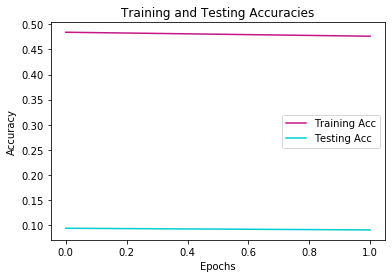

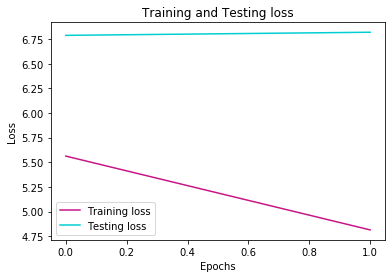

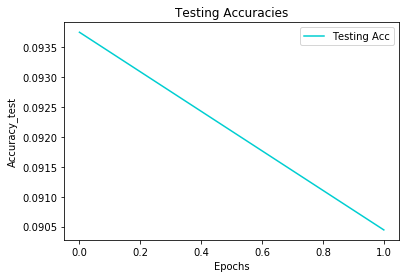

----- EPOCH ------- 
 3
Epoch [3/20], Batch [10/68], Loss: 4.0175, Accuracy: 0.4730
Epoch [3/20], Batch [20/68], Loss: 4.1077, Accuracy: 0.4710
Epoch [3/20], Batch [30/68], Loss: 3.8419, Accuracy: 0.4960
Epoch [3/20], Batch [40/68], Loss: 3.8300, Accuracy: 0.4897
Epoch [3/20], Batch [50/68], Loss: 3.6245, Accuracy: 0.4905
Epoch [3/20], Batch [60/68], Loss: 3.5200, Accuracy: 0.4956
Epoch [3/20], Batch [40/52], Loss: 8.1507, Accuracy: 0.1277


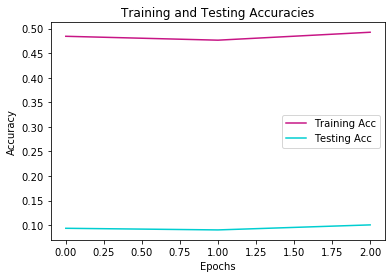

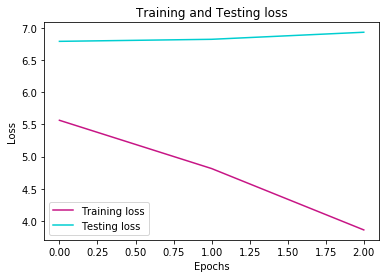

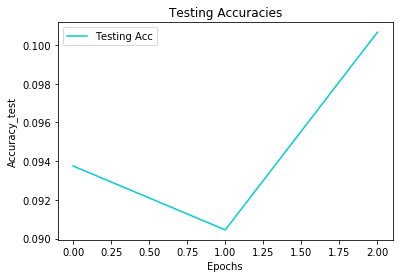

----- EPOCH ------- 
 4
Epoch [4/20], Batch [10/68], Loss: 3.3321, Accuracy: 0.5227
Epoch [4/20], Batch [20/68], Loss: 2.8871, Accuracy: 0.4799
Epoch [4/20], Batch [30/68], Loss: 2.9946, Accuracy: 0.4607
Epoch [4/20], Batch [40/68], Loss: 2.7988, Accuracy: 0.4562
Epoch [4/20], Batch [50/68], Loss: 2.7558, Accuracy: 0.4715
Epoch [4/20], Batch [60/68], Loss: 2.9412, Accuracy: 0.4813
Epoch [4/20], Batch [40/52], Loss: 8.2858, Accuracy: 0.1200


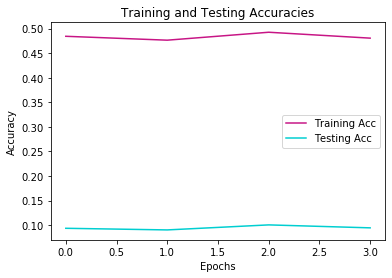

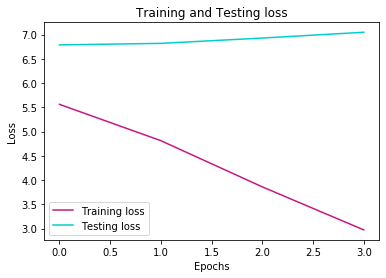

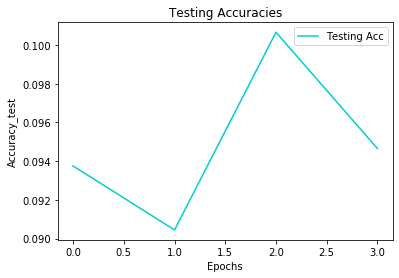

----- EPOCH ------- 
 5
Epoch [5/20], Batch [10/68], Loss: 2.8933, Accuracy: 0.4815
Epoch [5/20], Batch [20/68], Loss: 2.5526, Accuracy: 0.4814
Epoch [5/20], Batch [30/68], Loss: 2.5243, Accuracy: 0.5071
Epoch [5/20], Batch [40/68], Loss: 2.2063, Accuracy: 0.5042
Epoch [5/20], Batch [50/68], Loss: 2.5292, Accuracy: 0.5067
Epoch [5/20], Batch [60/68], Loss: 2.4447, Accuracy: 0.4997
Epoch [5/20], Batch [40/52], Loss: 8.3708, Accuracy: 0.1284
Training Loss:  2.4012469474007103
Training Accuracy:  0.5020680147058824
Train losses:
[5.56267627547769, 4.813223986064687, 3.8604974886950325, 2.9729002363541546, 2.4012469474007103]
Test losses:
[6.788289015109722, 6.819939970970154, 6.92958741921645, 7.049282211523789, 7.164851014430706]



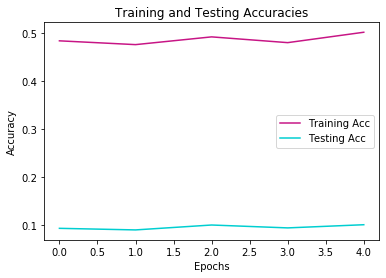

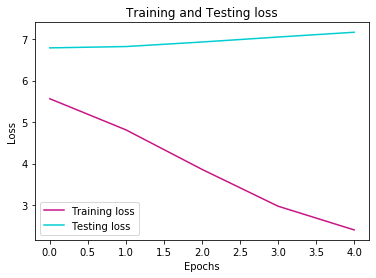

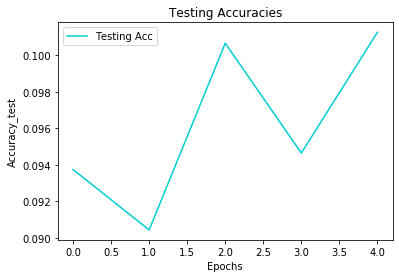

----- EPOCH ------- 
 6
Epoch [6/20], Batch [10/68], Loss: 2.2103, Accuracy: 0.4901
Epoch [6/20], Batch [20/68], Loss: 1.9764, Accuracy: 0.4940
Epoch [6/20], Batch [30/68], Loss: 2.2454, Accuracy: 0.5101
Epoch [6/20], Batch [40/68], Loss: 2.1890, Accuracy: 0.5091
Epoch [6/20], Batch [50/68], Loss: 1.7222, Accuracy: 0.5119
Epoch [6/20], Batch [60/68], Loss: 2.1287, Accuracy: 0.5138
Epoch [6/20], Batch [40/52], Loss: 8.5495, Accuracy: 0.1608


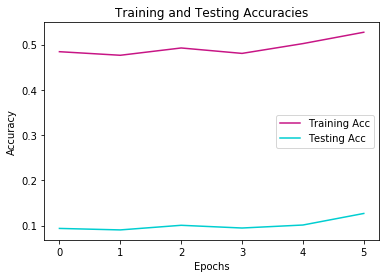

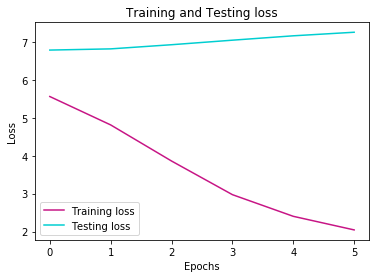

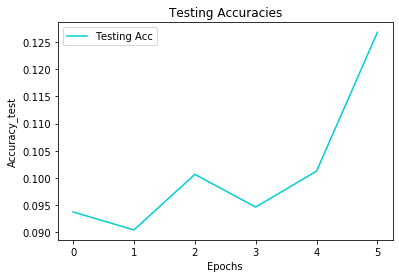

----- EPOCH ------- 
 7
Epoch [7/20], Batch [10/68], Loss: 1.6823, Accuracy: 0.6094
Epoch [7/20], Batch [20/68], Loss: 1.6745, Accuracy: 0.6057
Epoch [7/20], Batch [30/68], Loss: 1.7641, Accuracy: 0.5801
Epoch [7/20], Batch [40/68], Loss: 1.7521, Accuracy: 0.5838
Epoch [7/20], Batch [50/68], Loss: 1.7925, Accuracy: 0.5818
Epoch [7/20], Batch [60/68], Loss: 2.0547, Accuracy: 0.5599
Epoch [7/20], Batch [40/52], Loss: 8.6405, Accuracy: 0.1582


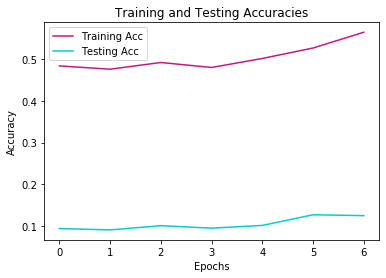

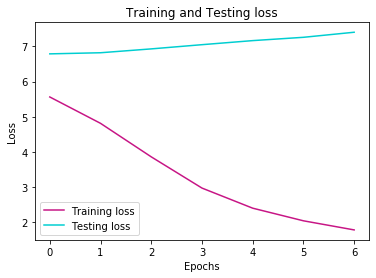

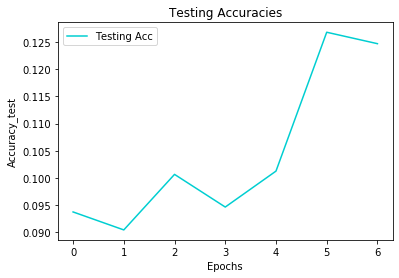

----- EPOCH ------- 
 8
Epoch [8/20], Batch [10/68], Loss: 1.5528, Accuracy: 0.5582
Epoch [8/20], Batch [20/68], Loss: 1.5912, Accuracy: 0.5670
Epoch [8/20], Batch [30/68], Loss: 1.7445, Accuracy: 0.5696
Epoch [8/20], Batch [40/68], Loss: 1.6002, Accuracy: 0.5899
Epoch [8/20], Batch [50/68], Loss: 2.0576, Accuracy: 0.5934
Epoch [8/20], Batch [60/68], Loss: 1.6082, Accuracy: 0.5822
Epoch [8/20], Batch [40/52], Loss: 8.7561, Accuracy: 0.1825


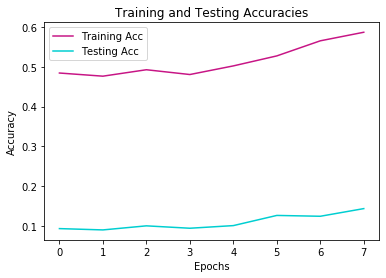

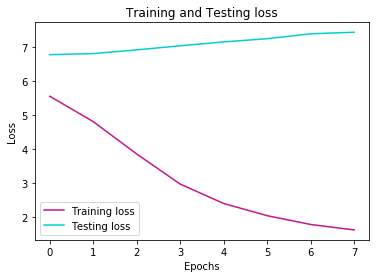

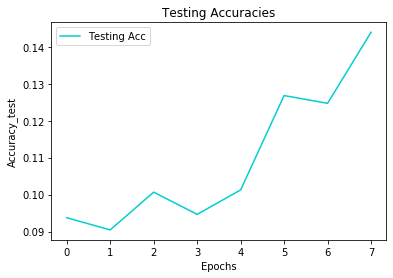

----- EPOCH ------- 
 9
Epoch [9/20], Batch [10/68], Loss: 1.4777, Accuracy: 0.5767
Epoch [9/20], Batch [20/68], Loss: 1.3375, Accuracy: 0.5655
Epoch [9/20], Batch [30/68], Loss: 1.5170, Accuracy: 0.5499
Epoch [9/20], Batch [40/68], Loss: 1.3392, Accuracy: 0.5454
Epoch [9/20], Batch [50/68], Loss: 1.4659, Accuracy: 0.5401
Epoch [9/20], Batch [60/68], Loss: 1.4843, Accuracy: 0.5492
Epoch [9/20], Batch [40/52], Loss: 8.8805, Accuracy: 0.1726
Training Loss:  1.5019094663507797
Training Accuracy:  0.5597886029411764
Train losses:
[5.56267627547769, 4.813223986064687, 3.8604974886950325, 2.9729002363541546, 2.4012469474007103, 2.0424355145762947, 1.783345755408792, 1.6230780710192287, 1.5019094663507797]
Test losses:
[6.788289015109722, 6.819939970970154, 6.92958741921645, 7.049282211523789, 7.164851014430706, 7.258866154230558, 7.402832563106831, 7.4489611020455, 7.593795565458445]



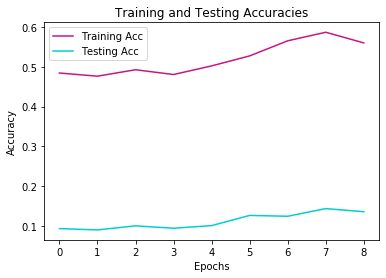

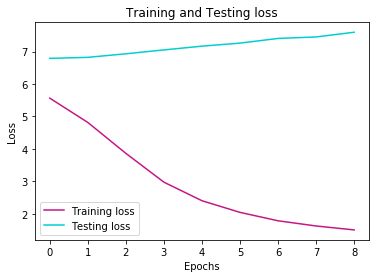

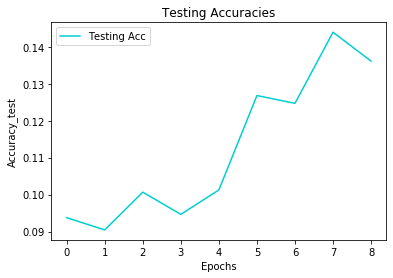

----- EPOCH ------- 
 10
Epoch [10/20], Batch [10/68], Loss: 1.2641, Accuracy: 0.5838
Epoch [10/20], Batch [20/68], Loss: 1.5639, Accuracy: 0.5878
Epoch [10/20], Batch [30/68], Loss: 1.4657, Accuracy: 0.6038
Epoch [10/20], Batch [40/68], Loss: 1.2823, Accuracy: 0.5979
Epoch [10/20], Batch [50/68], Loss: 1.6282, Accuracy: 0.5950
Epoch [10/20], Batch [60/68], Loss: 1.4530, Accuracy: 0.5966
Epoch [10/20], Batch [40/52], Loss: 8.9252, Accuracy: 0.1391


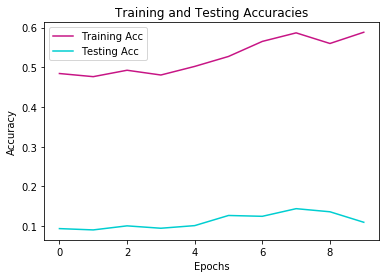

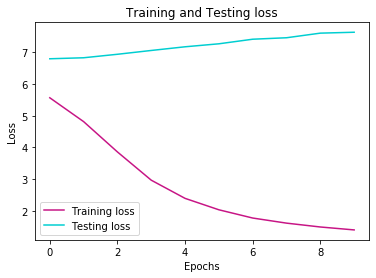

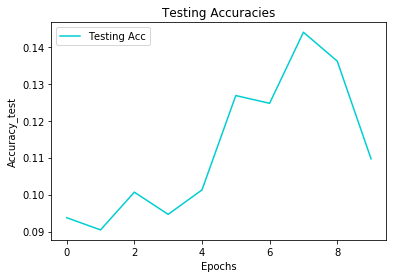

----- EPOCH ------- 
 11
Epoch [11/20], Batch [10/68], Loss: 1.2482, Accuracy: 0.5710
Epoch [11/20], Batch [20/68], Loss: 1.3097, Accuracy: 0.5499
Epoch [11/20], Batch [30/68], Loss: 1.2104, Accuracy: 0.5580
Epoch [11/20], Batch [40/68], Loss: 1.2514, Accuracy: 0.5629
Epoch [11/20], Batch [50/68], Loss: 1.4286, Accuracy: 0.5594
Epoch [11/20], Batch [60/68], Loss: 1.2742, Accuracy: 0.5566
Epoch [11/20], Batch [40/52], Loss: 9.0694, Accuracy: 0.1707


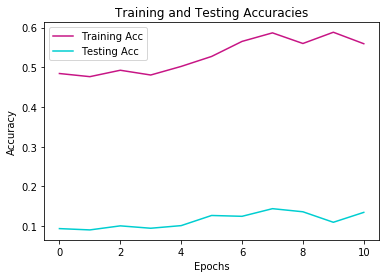

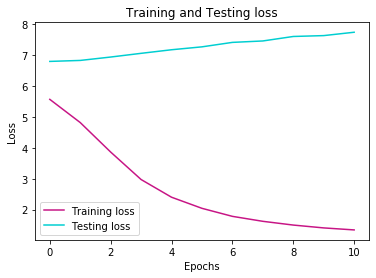

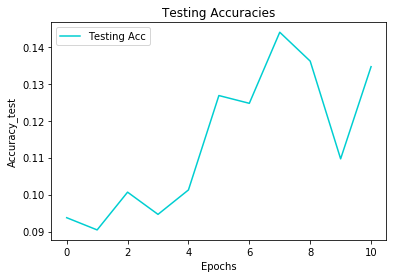

----- EPOCH ------- 
 12
Epoch [12/20], Batch [10/68], Loss: 1.3405, Accuracy: 0.5540
Epoch [12/20], Batch [20/68], Loss: 1.2130, Accuracy: 0.5744
Epoch [12/20], Batch [30/68], Loss: 1.3585, Accuracy: 0.5832
Epoch [12/20], Batch [40/68], Loss: 1.1471, Accuracy: 0.5884
Epoch [12/20], Batch [50/68], Loss: 1.3037, Accuracy: 0.5763
Epoch [12/20], Batch [60/68], Loss: 1.3679, Accuracy: 0.5758
Epoch [12/20], Batch [40/52], Loss: 9.0720, Accuracy: 0.1662


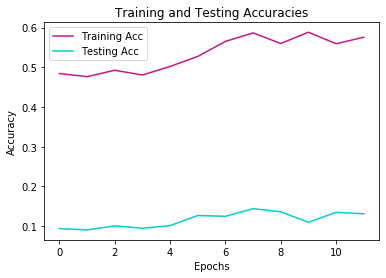

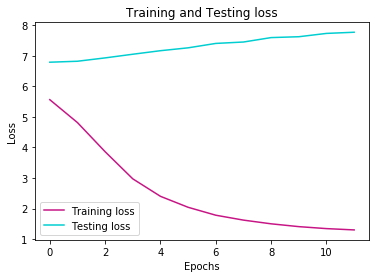

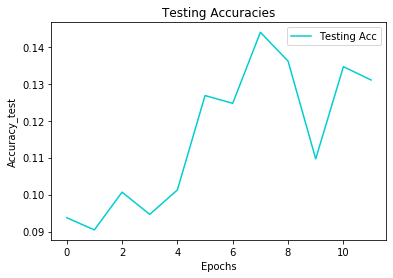

----- EPOCH ------- 
 13
Epoch [13/20], Batch [10/68], Loss: 1.2083, Accuracy: 0.5611
Epoch [13/20], Batch [20/68], Loss: 1.1226, Accuracy: 0.5751
Epoch [13/20], Batch [30/68], Loss: 1.1768, Accuracy: 0.5726
Epoch [13/20], Batch [40/68], Loss: 1.5794, Accuracy: 0.5629
Epoch [13/20], Batch [50/68], Loss: 1.2841, Accuracy: 0.5650
Epoch [13/20], Batch [60/68], Loss: 1.2539, Accuracy: 0.5756
Epoch [13/20], Batch [40/52], Loss: 9.1793, Accuracy: 0.1589
Training Loss:  1.2632148563861847
Training Accuracy:  0.5681525735294117
Train losses:
[5.56267627547769, 4.813223986064687, 3.8604974886950325, 2.9729002363541546, 2.4012469474007103, 2.0424355145762947, 1.783345755408792, 1.6230780710192287, 1.5019094663507797, 1.4099596843999975, 1.3452640210880953, 1.3026289273710812, 1.2632148563861847]
Test losses:
[6.788289015109722, 6.819939970970154, 6.92958741921645, 7.049282211523789, 7.164851014430706, 7.258866154230558, 7.402832563106831, 7.4489611020455, 7.593795565458445, 7.621959649599516, 7.

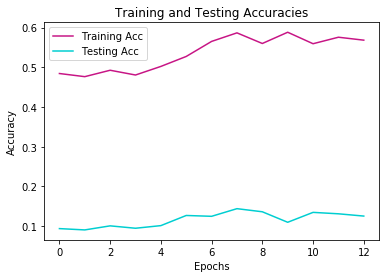

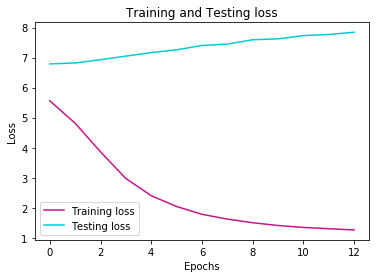

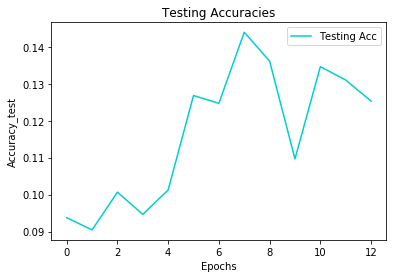

----- EPOCH ------- 
 14
Epoch [14/20], Batch [10/68], Loss: 1.1408, Accuracy: 0.5213
Epoch [14/20], Batch [20/68], Loss: 1.2621, Accuracy: 0.5543
Epoch [14/20], Batch [30/68], Loss: 1.2018, Accuracy: 0.5736
Epoch [14/20], Batch [40/68], Loss: 0.9946, Accuracy: 0.5827
Epoch [14/20], Batch [50/68], Loss: 1.1436, Accuracy: 0.5757
Epoch [14/20], Batch [60/68], Loss: 1.3026, Accuracy: 0.5768
Epoch [14/20], Batch [40/52], Loss: 9.2214, Accuracy: 0.1490


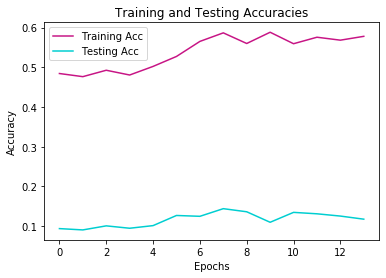

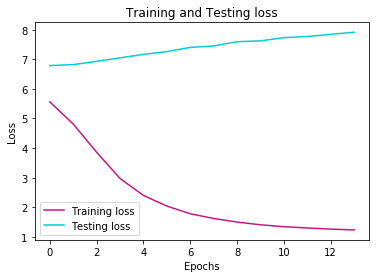

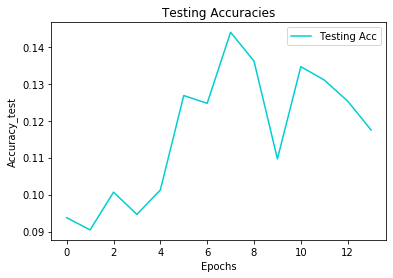

----- EPOCH ------- 
 15
Epoch [15/20], Batch [10/68], Loss: 1.1213, Accuracy: 0.5938
Epoch [15/20], Batch [20/68], Loss: 1.0530, Accuracy: 0.5766
Epoch [15/20], Batch [30/68], Loss: 0.9842, Accuracy: 0.5872
Epoch [15/20], Batch [40/68], Loss: 1.2967, Accuracy: 0.5781
Epoch [15/20], Batch [50/68], Loss: 1.1693, Accuracy: 0.5594
Epoch [15/20], Batch [60/68], Loss: 1.2263, Accuracy: 0.5645
Epoch [15/20], Batch [40/52], Loss: 9.2672, Accuracy: 0.1597


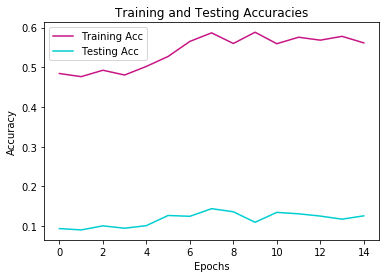

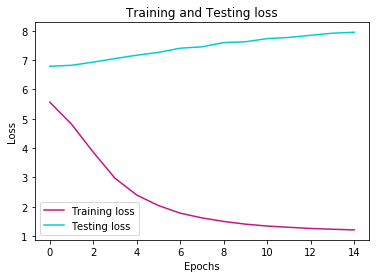

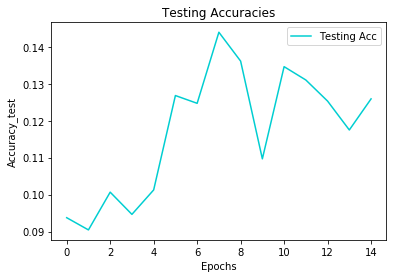

----- EPOCH ------- 
 16
Epoch [16/20], Batch [10/68], Loss: 1.1647, Accuracy: 0.5852
Epoch [16/20], Batch [20/68], Loss: 1.5901, Accuracy: 0.5528
Epoch [16/20], Batch [30/68], Loss: 1.2765, Accuracy: 0.5519
Epoch [16/20], Batch [40/68], Loss: 1.1284, Accuracy: 0.5442
Epoch [16/20], Batch [50/68], Loss: 1.1211, Accuracy: 0.5358
Epoch [16/20], Batch [60/68], Loss: 1.1147, Accuracy: 0.5556
Epoch [16/20], Batch [40/52], Loss: 9.3320, Accuracy: 0.1570


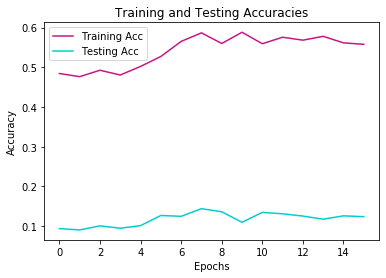

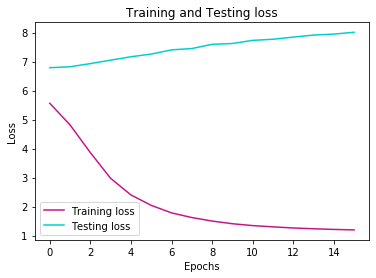

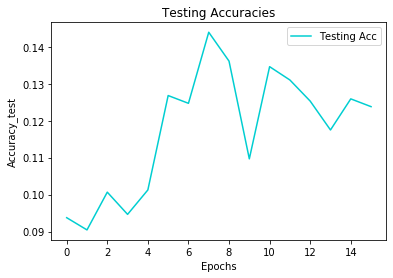

----- EPOCH ------- 
 17
Epoch [17/20], Batch [10/68], Loss: 1.1661, Accuracy: 0.5668
Epoch [17/20], Batch [20/68], Loss: 1.1418, Accuracy: 0.5350
Epoch [17/20], Batch [30/68], Loss: 1.0353, Accuracy: 0.5217
Epoch [17/20], Batch [40/68], Loss: 1.1483, Accuracy: 0.5137
Epoch [17/20], Batch [50/68], Loss: 1.2012, Accuracy: 0.5267
Epoch [17/20], Batch [60/68], Loss: 1.0795, Accuracy: 0.5338
Epoch [17/20], Batch [40/52], Loss: 9.3927, Accuracy: 0.1311
Training Loss:  1.1833257473566954
Training Accuracy:  0.5365349264705882
Train losses:
[5.56267627547769, 4.813223986064687, 3.8604974886950325, 2.9729002363541546, 2.4012469474007103, 2.0424355145762947, 1.783345755408792, 1.6230780710192287, 1.5019094663507797, 1.4099596843999975, 1.3452640210880953, 1.3026289273710812, 1.2632148563861847, 1.2367996354313457, 1.2136122365208233, 1.19663646291284, 1.1833257473566954]
Test losses:
[6.788289015109722, 6.819939970970154, 6.92958741921645, 7.049282211523789, 7.164851014430706, 7.258866154230558

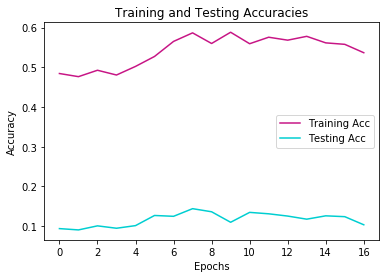

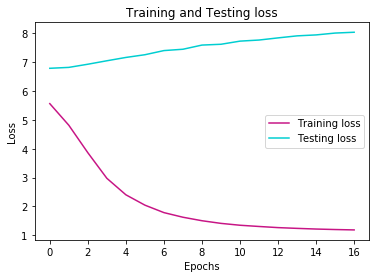

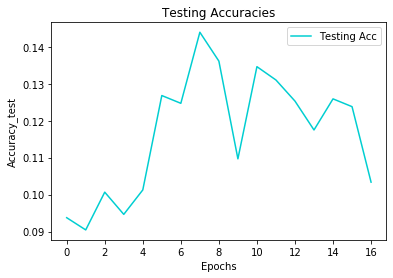

----- EPOCH ------- 
 18
Epoch [18/20], Batch [10/68], Loss: 1.0934, Accuracy: 0.5952
Epoch [18/20], Batch [20/68], Loss: 1.1845, Accuracy: 0.5632
Epoch [18/20], Batch [30/68], Loss: 1.2047, Accuracy: 0.5625
Epoch [18/20], Batch [40/68], Loss: 1.2100, Accuracy: 0.5431
Epoch [18/20], Batch [50/68], Loss: 1.1520, Accuracy: 0.5386
Epoch [18/20], Batch [60/68], Loss: 1.2381, Accuracy: 0.5369
Epoch [18/20], Batch [40/52], Loss: 9.3909, Accuracy: 0.1578


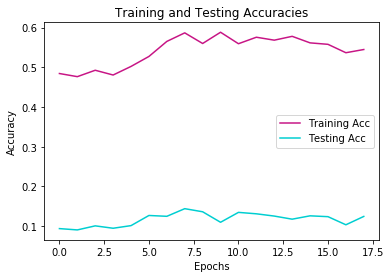

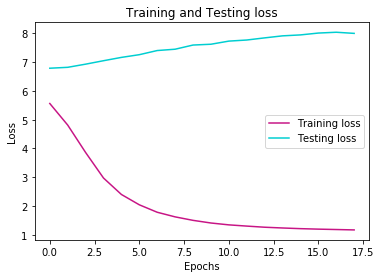

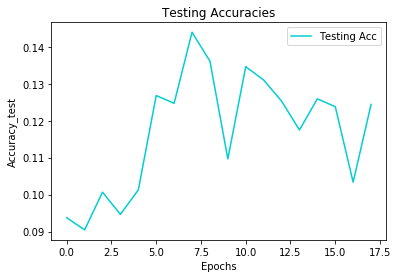

----- EPOCH ------- 
 19
Epoch [19/20], Batch [10/68], Loss: 1.2212, Accuracy: 0.5355
Epoch [19/20], Batch [20/68], Loss: 0.9859, Accuracy: 0.5365
Epoch [19/20], Batch [30/68], Loss: 1.1621, Accuracy: 0.5418
Epoch [19/20], Batch [40/68], Loss: 1.2328, Accuracy: 0.5412
Epoch [19/20], Batch [50/68], Loss: 1.1324, Accuracy: 0.5389
Epoch [19/20], Batch [60/68], Loss: 1.1934, Accuracy: 0.5502
Epoch [19/20], Batch [40/52], Loss: 9.3996, Accuracy: 0.1395


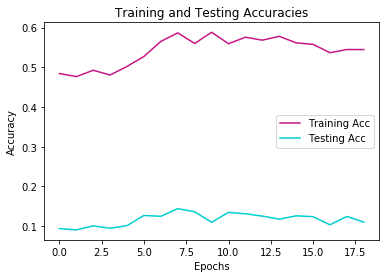

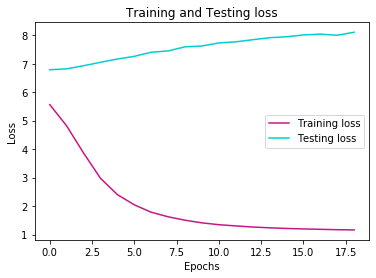

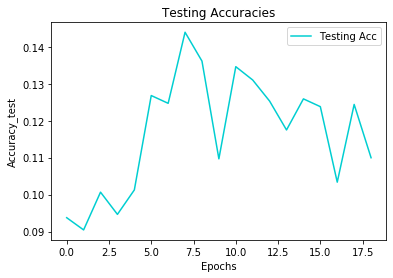

----- EPOCH ------- 
 20
Epoch [20/20], Batch [10/68], Loss: 1.0503, Accuracy: 0.5668
Epoch [20/20], Batch [20/68], Loss: 1.2165, Accuracy: 0.5521
Epoch [20/20], Batch [30/68], Loss: 1.2437, Accuracy: 0.5292
Epoch [20/20], Batch [40/68], Loss: 1.1498, Accuracy: 0.5492
Epoch [20/20], Batch [50/68], Loss: 1.0948, Accuracy: 0.5453
Epoch [20/20], Batch [60/68], Loss: 1.3003, Accuracy: 0.5528
Epoch [20/20], Batch [40/52], Loss: 9.4283, Accuracy: 0.1620


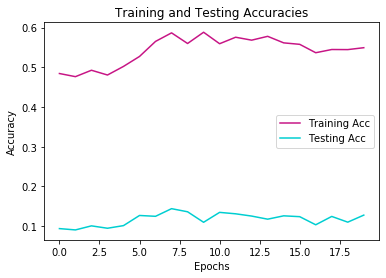

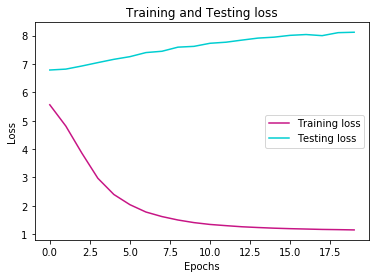

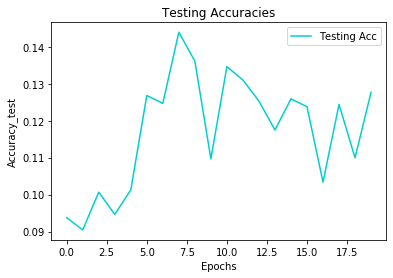

In [249]:
train_losses, test_losses, train_accs, test_accs = run_epochs(encoder, decoder, 
                                    optimizer, criterion, train_dataloader, val_dataloader, nepochs)

### Generating captions

In [250]:
def load_image(image_path, xform=None):
    image = Image.open(image_path)
    image = image.resize([64, 64], Image.LANCZOS)
    
    if xform is not None:
        image = xform(image).unsqueeze(0)
    
    return image

In [256]:
def word_ids2words(list_of_labels_ids):
    # Convert word_ids to words
    sampled_caption = []
    for word_id in list_of_labels_ids:
        word = VOCAB.idx2word[word_id]
#         print("word: ", word)
        sampled_caption.append(word)
#         if word == '<end>':
#             break
#     print("sampled caption: ", sampled_caption)
    sentence = ' '.join(sampled_caption)
    return sentence

In [257]:
def generate_caption_from_image(encoder, decoder, image_tensor):
    
    # Set model to eval
    encoder = encoder.eval()
    
    # Encode image
    feature = encoder(image_tensor)   
    
    # Get captions
    sampled_ids = decoder.sample_topk(feature)
#     print("sampled_ids: ", sampled_ids)
    # Convert tensor to numpy in cpu
    sampled_ids = sampled_ids[0] # (1, max_seq_length) -> (max_seq_length)
#     print("sampled_ids after moving to cpu and numpy: ", sampled_ids)
    return sampled_ids
    

In [258]:
def generate_labels(images):
    labels = []
    XFORMS = transforms.Compose([
        transforms.Resize((64, 64)),
        #transforms.RandomResizedCrop(100),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
    
    # Load models 
#     encoder = EncoderCNN(64)
#     enc_load = './saved_models/encoder-19.pth'
#     dec_load = './saved_models/decoder-19.pth'
#     encoder.load_state_dict(torch.load(enc_load, map_location=DEVICE))
#     decoder.load_state_dict(torch.load(dec_load, map_location=DEVICE))
    
    for image_ in images:
        # Attach path to image
#         image_name = dataset_new_folder + "/" + dataset.train_data[1]
        print("\nimage: ", image_)
        image_name = dataset_new_folder + "/" + image_
#         print("image_name: ", image_name)
        # Load image and apply transformations
        image = load_image(image_name, XFORMS)
        
        # Move to proper device
        image_tensor = image.to(device)
        
        # Generate an caption from the image
        sampled_ids = generate_caption_from_image(encoder, decoder, image_tensor)
        
        # Decode ids to words
        caption = word_ids2words(sampled_ids)
        
        # Print out the image and the generated caption
        
        image = Image.open(image_name)
        plt.imshow(np.asarray(image))
        plt.show(image)
        # Print ground truth labels
        print("\nGround truth labels: ", dataset.labels[image_])
        print ("\nGenerated labels: ", caption)


image:  d32ffcbc903ef64728040949acd02fc95560841c.jpg
predicted:  tensor([[  2, 473, 466]])
[[2, 473, 466]]


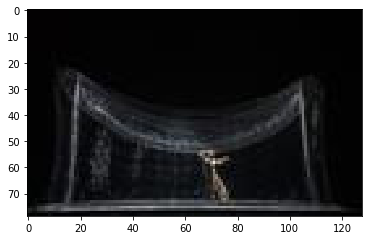


Ground truth labels:  ['other', 'rigid', 'well', 'entire', 'impossible', 'visual', 'amazing', 'real', 'more', 'inspired', 'emotional', 'new', '<end>']

Generated labels:  <end> dramatic tangible

image:  55bb7c7afcdeb6e2ee1ccee1cd4d5fc7c94d87c8.jpg
predicted:  tensor([[1183, 2754,  306]])
[[1183, 2754, 306]]


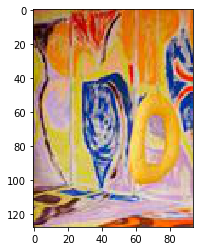


Ground truth labels:  ['puffy', 'creative', 'puffy', 'soothing', 'immersive', 'many', '<end>']

Generated labels:  crucial racial strong

image:  bbafa84ddcd1d270a7b8fd962861a994e3105adc.jpg
predicted:  tensor([[787, 675, 306]])
[[787, 675, 306]]


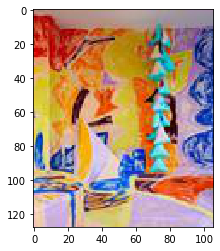


Ground truth labels:  ['puffy', 'creative', 'puffy', 'soothing', 'immersive', 'many', '<end>']

Generated labels:  universal organic strong

image:  76e03f3531e916ee4ba367b2192f0562fcec86d7.jpg
predicted:  tensor([[  2, 675, 525]])
[[2, 675, 525]]


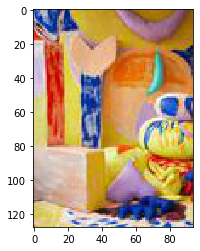


Ground truth labels:  ['puffy', 'creative', 'puffy', 'soothing', 'immersive', 'many', '<end>']

Generated labels:  <end> organic raw

image:  7c85fb17fef44e995b4bcebddc1d23b6a679e1be.jpg
predicted:  tensor([[  2,  97, 177]])
[[2, 97, 177]]


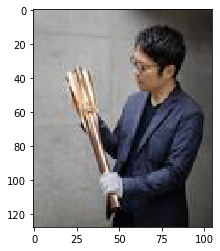


Ground truth labels:  ['single', 'like', 'seamless', 'simple', 'beautiful', 'superficial', 'polyhedral', 'different', 'memorable', 'curious', 'olympic', 'outstanding', 'different', 'stereotypical', 'japanese', 'innermost', 'well', 'important', 'new', 'excessive', 'functional', 'important', 'mass', '<end>']

Generated labels:  <end> natural more

image:  c654214d9b8f55c08505371431b40dd72e547917.jpg
predicted:  tensor([[  2,  70, 530]])
[[2, 70, 530]]


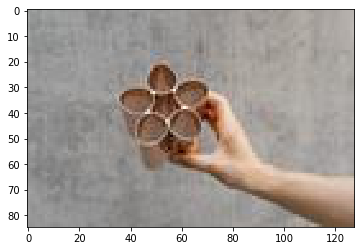


Ground truth labels:  ['single', 'like', 'seamless', 'simple', 'beautiful', 'superficial', 'polyhedral', 'different', 'memorable', 'curious', 'olympic', 'outstanding', 'different', 'stereotypical', 'japanese', 'innermost', 'well', 'important', 'new', 'excessive', 'functional', 'important', 'mass', '<end>']

Generated labels:  <end> powerful red

image:  9968b6e07a2df12fe886700ae34e4e3f02172edf.jpg
predicted:  tensor([[1081,  473,  412]])
[[1081, 473, 412]]


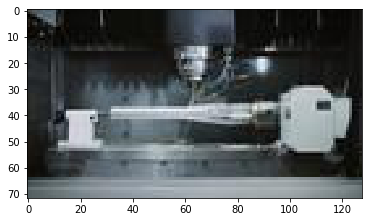


Ground truth labels:  ['single', 'like', 'seamless', 'simple', 'beautiful', 'superficial', 'polyhedral', 'different', 'memorable', 'curious', 'olympic', 'outstanding', 'different', 'stereotypical', 'japanese', 'innermost', 'well', 'important', 'new', 'excessive', 'functional', 'important', 'mass', '<end>']

Generated labels:  utopian dramatic beautiful

image:  d9ee8a30dd6fb5f8cee08aa93cae14bac4f3af25.jpg
predicted:  tensor([[382,  66, 133]])
[[382, 66, 133]]


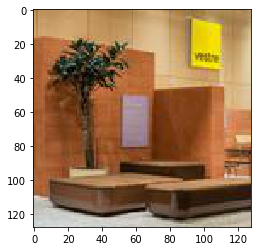


Ground truth labels:  ['minimal', 'natural', 'unprocessed', 'beautiful', 'natural', 'such', 'recyclable', 'reusable', 'modular', 'demountable', 'current', 'new', 'transparent', 'open', 'long', 'more', 'same', '<end>']

Generated labels:  scarce new incredible

image:  e96e663a713c14ab0e496608eb2e47af6ef4308a.jpg
predicted:  tensor([[121, 993, 309]])
[[121, 993, 309]]


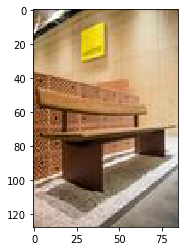


Ground truth labels:  ['minimal', 'natural', 'unprocessed', 'beautiful', 'natural', 'such', 'recyclable', 'reusable', 'modular', 'demountable', 'current', 'new', 'transparent', 'open', 'long', 'more', 'same', '<end>']

Generated labels:  solar smart intact

image:  cb13e00d7508850b2cf382a941f1a5b436a453fd.jpg
predicted:  tensor([[ 215,    2, 1218]])
[[215, 2, 1218]]


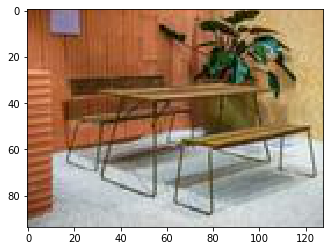


Ground truth labels:  ['minimal', 'natural', 'unprocessed', 'beautiful', 'natural', 'such', 'recyclable', 'reusable', 'modular', 'demountable', 'current', 'new', 'transparent', 'open', 'long', 'more', 'same', '<end>']

Generated labels:  sustainable <end> inherent

image:  a627cc9ee2e219064e4c0f6d7c071b6e66957161.jpg
predicted:  tensor([[  2, 119, 675]])
[[2, 119, 675]]


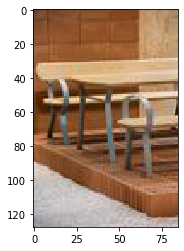


Ground truth labels:  ['minimal', 'natural', 'unprocessed', 'beautiful', 'natural', 'such', 'recyclable', 'reusable', 'modular', 'demountable', 'current', 'new', 'transparent', 'open', 'long', 'more', 'same', '<end>']

Generated labels:  <end> important organic

image:  b0fae7df69d8880702308b9fd14c36ded0a2e9e6.jpg
predicted:  tensor([[  2, 690, 229]])
[[2, 690, 229]]


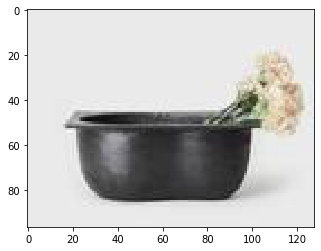


Ground truth labels:  ['sculptural', 'small', 'welcome', 'powerful', 'simple', 'big', 'dominant', 'new', 'former', 'innovative', 'final', 'new', '<end>']

Generated labels:  <end> futuristic dynamic

image:  7c712ed7910d7a0af066c2ee53fe6480e3e90f48.jpg
predicted:  tensor([[  2, 585, 305]])
[[2, 585, 305]]


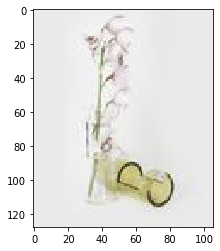


Ground truth labels:  ['sculptural', 'small', 'welcome', 'powerful', 'simple', 'big', 'dominant', 'new', 'former', 'innovative', 'final', 'new', '<end>']

Generated labels:  <end> soft easy

image:  e1768ffad8167e5c3344fe2b22dc9b7da7297cc2.jpg
predicted:  tensor([[ 15, 412,   2]])
[[15, 412, 2]]


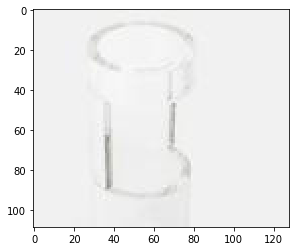


Ground truth labels:  ['sculptural', 'small', 'welcome', 'powerful', 'simple', 'big', 'dominant', 'new', 'former', 'innovative', 'final', 'new', '<end>']

Generated labels:  different beautiful <end>

image:  b71d6c972cb7b9a618d946483991813a9256df09.jpg
predicted:  tensor([[315, 585, 243]])
[[315, 585, 243]]


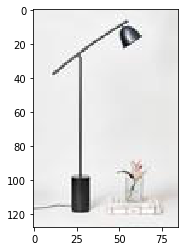


Ground truth labels:  ['sculptural', 'small', 'welcome', 'powerful', 'simple', 'big', 'dominant', 'new', 'former', 'innovative', 'final', 'new', '<end>']

Generated labels:  big soft historic

image:  2c027d9c89bf5f467b68973c11322004a593404d.jpg
predicted:  tensor([[278,   9, 125]])
[[278, 9, 125]]


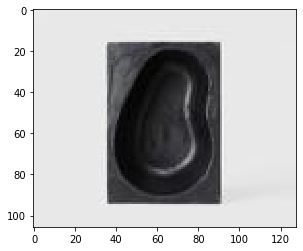


Ground truth labels:  ['sculptural', 'small', 'welcome', 'powerful', 'simple', 'big', 'dominant', 'new', 'former', 'innovative', 'final', 'new', '<end>']

Generated labels:  iconic same key

image:  29ff5cf0c5ef5c5e4da679c9bfc84ba199a9a2ea.jpg
predicted:  tensor([[  2, 960, 993]])
[[2, 960, 993]]


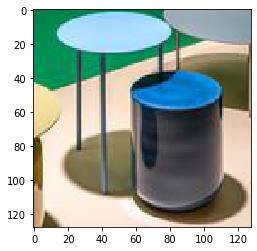


Ground truth labels:  ['dynamic', 'strong', 'playful', 'soft', 'glossy', 'interesting', 'cold', 'co', 'dependent', 'other', 'difficult', 'such', 'glazed', 'large', 'perfect', 'high', 'good', '<end>']

Generated labels:  <end> expressive smart

image:  c0a0c61075d65f91394034805dc4815e1ca5cad9.jpg
predicted:  tensor([[   2, 1027,   47]])
[[2, 1027, 47]]


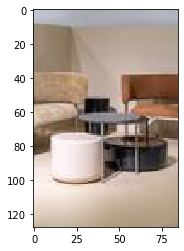


Ground truth labels:  ['dynamic', 'strong', 'playful', 'soft', 'glossy', 'interesting', 'cold', 'co', 'dependent', 'other', 'difficult', 'such', 'glazed', 'large', 'perfect', 'high', 'good', '<end>']

Generated labels:  <end> strict like

image:  b3bbc31a670bec1359c25c356e5aafcd03350838.jpg
predicted:  tensor([[722, 425, 514]])
[[722, 425, 514]]


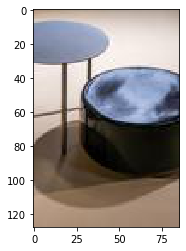


Ground truth labels:  ['dynamic', 'strong', 'playful', 'soft', 'glossy', 'interesting', 'cold', 'co', 'dependent', 'other', 'difficult', 'such', 'glazed', 'large', 'perfect', 'high', 'good', '<end>']

Generated labels:  elegant commercial abstract

image:  2412178daf66c01ebf95f48ef518027e603afd72.jpg
predicted:  tensor([[  2, 314,  35]])
[[2, 314, 35]]


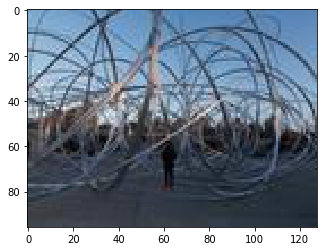


Ground truth labels:  ['subjective', 'personal', 'urban', 'high', 'open', 'incredible', 'actual', 'perfect', 'other', 'many', 'physical', 'human', '<end>']

Generated labels:  <end> aesthetic vertical

image:  28bf8d5f73d2dc8101b1c7d4bdf12fa67dfb3037.jpg
predicted:  tensor([[177, 288, 106]])
[[177, 288, 106]]


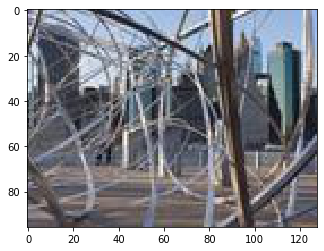


Ground truth labels:  ['subjective', 'personal', 'urban', 'high', 'open', 'incredible', 'actual', 'perfect', 'other', 'many', 'physical', 'human', '<end>']

Generated labels:  more white possible

image:  0737ada4dbe074e4606035be8695f42e66ae5215.jpg
predicted:  tensor([[318, 133, 979]])
[[318, 133, 979]]


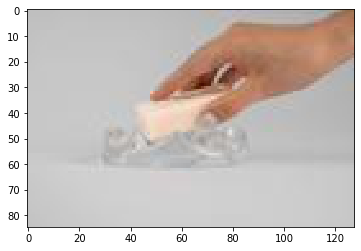


Ground truth labels:  ['cyclical', 'main', 'high', 'hard', 'impermeable', 'available', 'substantial', 'new', 'resistant', 'hybrid', 'easy', 'whole', 'additional', 'new', 'long', 'thin', 'small', 'round', 'beautiful', 'elegant', 'decorative', 'comfortable', '<end>']

Generated labels:  whole incredible dimensional

image:  4ef51c8bfd4edc78186e239aa5a8409d1bb09dea.jpg
predicted:  tensor([[177,   2, 117]])
[[177, 2, 117]]


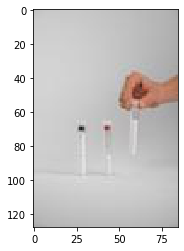


Ground truth labels:  ['cyclical', 'main', 'high', 'hard', 'impermeable', 'available', 'substantial', 'new', 'resistant', 'hybrid', 'easy', 'whole', 'additional', 'new', 'long', 'thin', 'small', 'round', 'beautiful', 'elegant', 'decorative', 'comfortable', '<end>']

Generated labels:  more <end> simple

image:  cbf71ceefbdb1a6210ac3ab8fa36944f3bbc085c.jpg
predicted:  tensor([[ 97,  76, 241]])
[[97, 76, 241]]


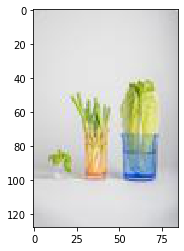


Ground truth labels:  ['cyclical', 'main', 'high', 'hard', 'impermeable', 'available', 'substantial', 'new', 'resistant', 'hybrid', 'easy', 'whole', 'additional', 'new', 'long', 'thin', 'small', 'round', 'beautiful', 'elegant', 'decorative', 'comfortable', '<end>']

Generated labels:  natural other delicate

image:  d17f9537934b9c92a9c74bd1475ffcfe080614e5.jpg
predicted:  tensor([[ 52, 230, 229]])
[[52, 230, 229]]


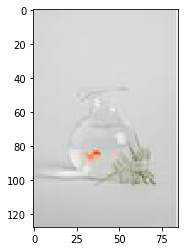


Ground truth labels:  ['cyclical', 'main', 'high', 'hard', 'impermeable', 'available', 'substantial', 'new', 'resistant', 'hybrid', 'easy', 'whole', 'additional', 'new', 'long', 'thin', 'small', 'round', 'beautiful', 'elegant', 'decorative', 'comfortable', '<end>']

Generated labels:  high wide dynamic

image:  b1b0f4c65869f1d6500689e63571f3259aed5ecb.jpg
predicted:  tensor([[  2, 215, 230]])
[[2, 215, 230]]


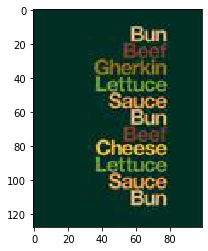


Ground truth labels:  ['recognisable', 'global', 'graphic', 'redacted', 'late', 'iconic', 'iconic', 'playful', 'tricky', 'minimalist', 'initial', 'strong', 'graphical', 'confident', 'visual', 'gentle', 'humble', '<end>']

Generated labels:  <end> sustainable wide

image:  409114953c347063a60a514f00e3834b8506ab59.jpg
predicted:  tensor([[230,  88, 720]])
[[230, 88, 720]]


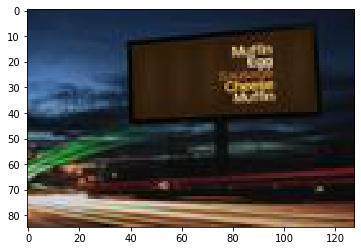


Ground truth labels:  ['recognisable', 'global', 'graphic', 'redacted', 'late', 'iconic', 'iconic', 'playful', 'tricky', 'minimalist', 'initial', 'strong', 'graphical', 'confident', 'visual', 'gentle', 'humble', '<end>']

Generated labels:  wide public chinese

image:  065302d82e96384b8eec611e57d19de1663a788a.jpg
predicted:  tensor([[134, 856, 418]])
[[134, 856, 418]]


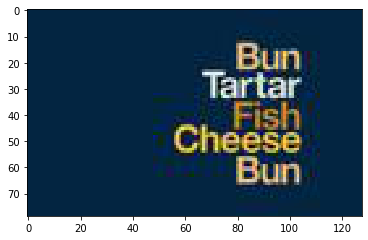


Ground truth labels:  ['recognisable', 'global', 'graphic', 'redacted', 'late', 'iconic', 'iconic', 'playful', 'tricky', 'minimalist', 'initial', 'strong', 'graphical', 'confident', 'visual', 'gentle', 'humble', '<end>']

Generated labels:  environmental third future

image:  78b6d708e5481cecddc78c78e6fb148e94a42069.jpg
predicted:  tensor([[   2, 1081,   97]])
[[2, 1081, 97]]


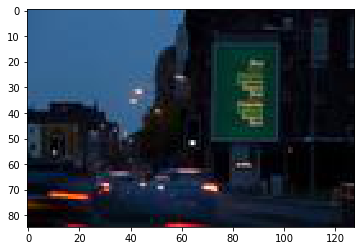


Ground truth labels:  ['recognisable', 'global', 'graphic', 'redacted', 'late', 'iconic', 'iconic', 'playful', 'tricky', 'minimalist', 'initial', 'strong', 'graphical', 'confident', 'visual', 'gentle', 'humble', '<end>']

Generated labels:  <end> utopian natural

image:  9c7ee6781bd7d6b8ee141e5d991aabc37591de78.jpg
predicted:  tensor([[ 36, 177,  66]])
[[36, 177, 66]]


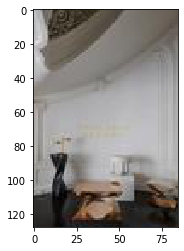


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  traditional more new

image:  e0d76c6625453338b7ecb312bc3959083e786348.jpg
predicted:  tensor([[412, 516,  89]])
[[412, 516, 89]]


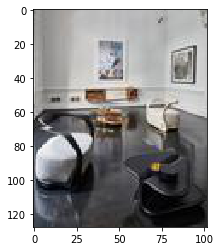


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  beautiful curved human

image:  b5c68f3780994df0cbff89bffa1c94e16f765108.jpg
predicted:  tensor([[  2, 466, 438]])
[[2, 466, 438]]


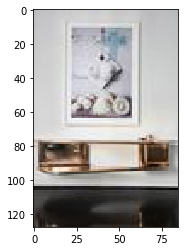


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  <end> tangible entire

image:  9f1fc003722035c53aadfd84e1ef527d45d0e8d4.jpg
predicted:  tensor([[412,  84,  79]])
[[412, 84, 79]]


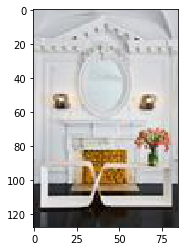


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  beautiful next clear

image:  ee04fbfb10c1faa3b5546d2aabd6e6695fae1823.jpg
predicted:  tensor([[ 66, 412,  52]])
[[66, 412, 52]]


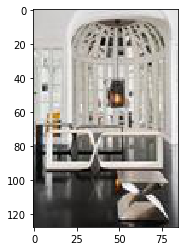


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  new beautiful high

image:  d30f3edab274f64ac67818b5c07767a1bdebf6fc.jpg
predicted:  tensor([[  2, 418,  76]])
[[2, 418, 76]]


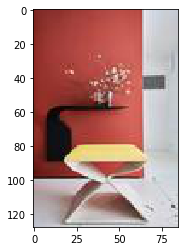


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  <end> future other

image:  cde2583f3dba83dfb10636872e391c1698e81817.jpg
predicted:  tensor([[ 89,  97, 130]])
[[89, 97, 130]]


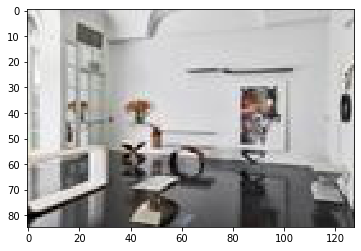


Ground truth labels:  ['modern', 'white', 'beautiful', 'classical', 'available', 'light', 'recognisable', 'elliptical', 'several', 'different', 'late', 'second', 'double', 'such', 'curved', '<end>']

Generated labels:  human natural contemporary

image:  e742490d5b4c8b08331f7b022589644d5714896f.jpg
predicted:  tensor([[412,  97,  89]])
[[412, 97, 89]]


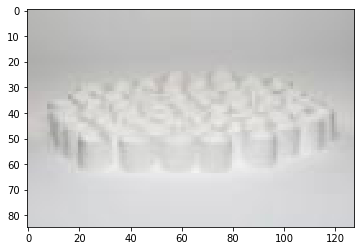


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  beautiful natural human

image:  b0815af2cb15ae3f4343c025c2c3858e81498137.jpg
predicted:  tensor([[  2,  70, 722]])
[[2, 70, 722]]


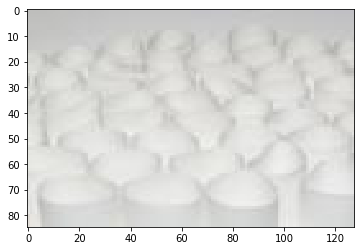


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  <end> powerful elegant

image:  cf7d30df03220471324132d033b7711723e1984c.jpg
predicted:  tensor([[284, 979, 525]])
[[284, 979, 525]]


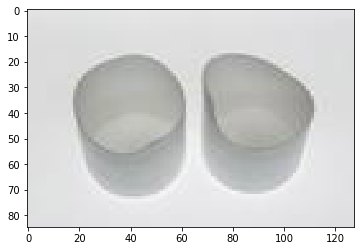


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  creative dimensional raw

image:  850c3ee6dedfa7b0db8d8d732e82fb9f9f790692.jpg
predicted:  tensor([[ 52, 339,  68]])
[[52, 339, 68]]


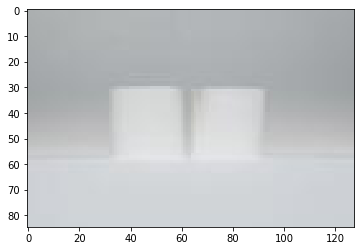


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  high rich first

image:  611bf7a0c863a2ef47a5087305c767e8fd2a7f04.jpg
predicted:  tensor([[  2,  70, 221]])
[[2, 70, 221]]


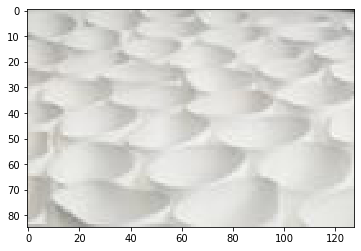


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  <end> powerful circular

image:  a8e37ec840c634eb9ee8feae1770de2f824a2a09.jpg
predicted:  tensor([[  2, 979, 487]])
[[2, 979, 487]]


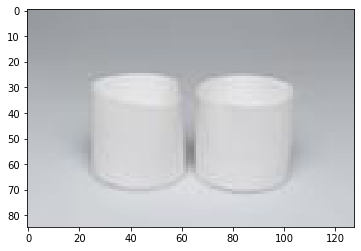


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  <end> dimensional near

image:  4f32c2198c2a14c643fcb6702f39d16e45eca3f8.jpg
predicted:  tensor([[  2,  70, 572]])
[[2, 70, 572]]


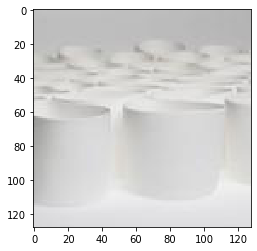


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  <end> powerful mixed

image:  3b56e19d8012d4238d3ba861843654af3cfe5ecb.jpg
predicted:  tensor([[  2, 450, 113]])
[[2, 450, 113]]


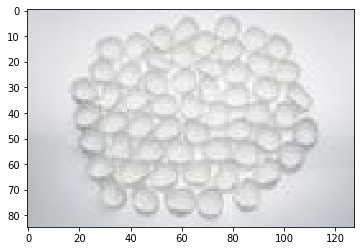


Ground truth labels:  ['mixed', 'other', 'less', 'thin', 'possible', 'alive', 'mineralogical', 'only', 'geological', 'whole', 'physical', 'different', 'present', 'low', 'able', 'new', 'same', '<end>']

Generated labels:  <end> french former

image:  5812fe006413fd335a83021fe4a95dfdeb0843de.jpg
predicted:  tensor([[450, 221, 835]])
[[450, 221, 835]]


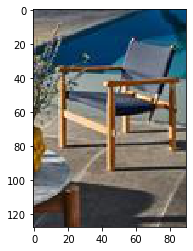


Ground truth labels:  ['rough', 'natural', 'thick', 'strong', 'outdoor', 'different', 'open', 'strong', 'outdoor', 'complete', 'fundamental', 'warm', 'different', 'faithful', 'diverse', 'experimental', '<end>']

Generated labels:  french circular negative

image:  5a4a42485115fa62c9847b0b70469573150f279f.jpg
predicted:  tensor([[91, 66, 39]])
[[91, 66, 39]]


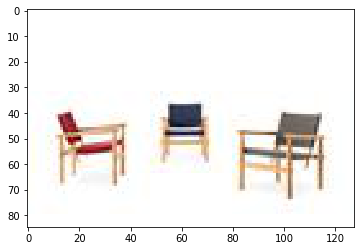


Ground truth labels:  ['rough', 'natural', 'thick', 'strong', 'outdoor', 'different', 'open', 'strong', 'outdoor', 'complete', 'fundamental', 'warm', 'different', 'faithful', 'diverse', 'experimental', '<end>']

Generated labels:  main new small

image:  ab9955bb733c81e75ca054174dcaa74e2c8e4a98.jpg
predicted:  tensor([[ 42, 543,  64]])
[[42, 543, 64]]


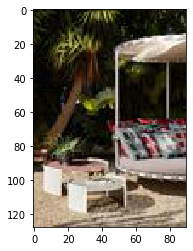


Ground truth labels:  ['rough', 'natural', 'thick', 'strong', 'outdoor', 'different', 'open', 'strong', 'outdoor', 'complete', 'fundamental', 'warm', 'different', 'faithful', 'diverse', 'experimental', '<end>']

Generated labels:  architectural tactile maximum

image:  2dbbb7db6128a9e5253c4d500ace79b36871301e.jpg
predicted:  tensor([[979, 410, 225]])
[[979, 410, 225]]


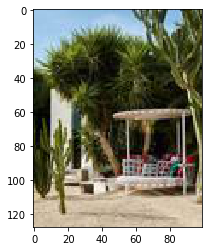


Ground truth labels:  ['rough', 'natural', 'thick', 'strong', 'outdoor', 'different', 'open', 'strong', 'outdoor', 'complete', 'fundamental', 'warm', 'different', 'faithful', 'diverse', 'experimental', '<end>']

Generated labels:  dimensional formal positive

image:  b968357d1f49b6d677052fadd8536de694ad4b3b.jpg
predicted:  tensor([[134, 121, 514]])
[[134, 121, 514]]


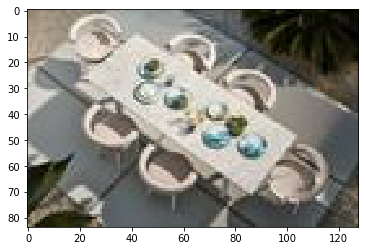


Ground truth labels:  ['rough', 'natural', 'thick', 'strong', 'outdoor', 'different', 'open', 'strong', 'outdoor', 'complete', 'fundamental', 'warm', 'different', 'faithful', 'diverse', 'experimental', '<end>']

Generated labels:  environmental solar abstract

image:  5839cfcbfc3f9e876700bb12263f3c1f051da319.jpg
predicted:  tensor([[  2, 490, 117]])
[[2, 490, 117]]


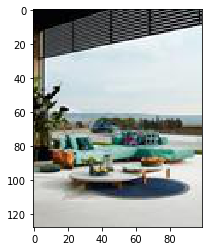


Ground truth labels:  ['rough', 'natural', 'thick', 'strong', 'outdoor', 'different', 'open', 'strong', 'outdoor', 'complete', 'fundamental', 'warm', 'different', 'faithful', 'diverse', 'experimental', '<end>']

Generated labels:  <end> ceramic simple


In [262]:
generate_labels(dataset.val_d[1000:1050])

In [255]:
from ctcdecode import CTCBeamDecoder
from Levenshtein import distance as levenshtein_distance

In [ ]:
name =  dataset.train_data[1]

In [ ]:
dataset.labels[name]